In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import sklearn as sk
from math import sqrt
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM as bbmg
from dmba import classificationSummary
from collections import Counter
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as SamplingPipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
thresh = 0.5
data = pd.read_csv('fraud_oracle.csv')

# Using the top 10 features we have from the Chi Squared test

In [3]:
# From - https://stackoverflow.com/questions/50607740/reverse-a-get-dummies-encoding-in-pandas
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [4]:
data = data[['NumberOfCars', 'Fault', 'VehiclePrice', 'VehicleCategory', 'PolicyType',
            'WitnessPresent', 'Make', 'BasePolicy' , 'AgeOfVehicle', 'PastNumberOfClaims','FraudFound_P']]

DataTop10 = data
print(data.head())

  NumberOfCars          Fault     VehiclePrice VehicleCategory  \
0       3 to 4  Policy Holder  more than 69000           Sport   
1    1 vehicle  Policy Holder  more than 69000           Sport   
2    1 vehicle  Policy Holder  more than 69000           Sport   
3    1 vehicle    Third Party   20000 to 29000           Sport   
4    1 vehicle    Third Party  more than 69000           Sport   

          PolicyType WitnessPresent    Make BasePolicy AgeOfVehicle  \
0  Sport - Liability             No   Honda  Liability      3 years   
1  Sport - Collision             No   Honda  Collision      6 years   
2  Sport - Collision             No   Honda  Collision      7 years   
3  Sedan - Liability             No  Toyota  Liability  more than 7   
4  Sport - Collision             No   Honda  Collision      5 years   

  PastNumberOfClaims  FraudFound_P  
0               none             0  
1               none             0  
2                  1             0  
3                  1        

In [5]:
#create dummies 
DummiesData = pd.get_dummies(data)
DummiesData.shape
DummiesData.columns

Index(['FraudFound_P', 'NumberOfCars_1 vehicle', 'NumberOfCars_2 vehicles',
       'NumberOfCars_3 to 4', 'NumberOfCars_5 to 8',
       'NumberOfCars_more than 8', 'Fault_Policy Holder', 'Fault_Third Party',
       'VehiclePrice_20000 to 29000', 'VehiclePrice_30000 to 39000',
       'VehiclePrice_40000 to 59000', 'VehiclePrice_60000 to 69000',
       'VehiclePrice_less than 20000', 'VehiclePrice_more than 69000',
       'VehicleCategory_Sedan', 'VehicleCategory_Sport',
       'VehicleCategory_Utility', 'PolicyType_Sedan - All Perils',
       'PolicyType_Sedan - Collision', 'PolicyType_Sedan - Liability',
       'PolicyType_Sport - All Perils', 'PolicyType_Sport - Collision',
       'PolicyType_Sport - Liability', 'PolicyType_Utility - All Perils',
       'PolicyType_Utility - Collision', 'PolicyType_Utility - Liability',
       'WitnessPresent_No', 'WitnessPresent_Yes', 'Make_Accura', 'Make_BMW',
       'Make_Chevrolet', 'Make_Dodge', 'Make_Ferrari', 'Make_Ford',
       'Make_Honda', '

# SMOTE Sampling - Creating the dataset

In [6]:
# SMOTE Sampling 

X = DummiesData.drop(columns=['FraudFound_P'])
y = DummiesData['FraudFound_P']

counter = Counter(y)
print(counter)

DataSets = list()

for i in range(20):
    over = SMOTE(random_state=i)
    under = RandomUnderSampler(sampling_strategy=1)
    steps = [('o', over), ('u', under)]
    SMOTESampling = SamplingPipeline(steps=steps)

    X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)
    # summarize the new class distribution
    counter = Counter(y_resampled)
    
    if i == 1:
        print(counter)

    # Verifying un dummify works
    X_resampled = undummify(X_resampled)
    
    if i == 1:
        print(X_resampled.head())

    X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

    if i == 1:
        counter = Counter(y_train)
        print(counter)
        counter = Counter(y_valid)
        print(counter)

    X_train['FraudFound_P'] = y_train
    X_valid['FraudFound_P'] = y_valid

    #print(X_train.head())
    print(X_train.shape)
    
    DataSets.append([X_train, y_train, X_valid, y_valid])

Counter({0: 14497, 1: 923})
(17396, 11)
Counter({0: 14497, 1: 14497})
  NumberOfCars          Fault     VehiclePrice VehicleCategory  \
0       3 to 4  Policy Holder  more than 69000           Sport   
1    1 vehicle  Policy Holder  more than 69000           Sport   
2    1 vehicle  Policy Holder  more than 69000           Sport   
3    1 vehicle    Third Party   20000 to 29000           Sport   
4    1 vehicle    Third Party  more than 69000           Sport   

          PolicyType WitnessPresent    Make BasePolicy AgeOfVehicle  \
0  Sport - Liability             No   Honda  Liability      3 years   
1  Sport - Collision             No   Honda  Collision      6 years   
2  Sport - Collision             No   Honda  Collision      7 years   
3  Sedan - Liability             No  Toyota  Liability  more than 7   
4  Sport - Collision             No   Honda  Collision      5 years   

  PastNumberOfClaims  
0               none  
1               none  
2                  1  
3             

In [7]:
len(DataSets)

20

# SMOTE Modelling - Multi Level Modelling with Number of Cars

Starting i = 0
Area under curve for train dataset is -  0.8012729000993692
(11598, 54)
Starting i = 1
                             Binomial Mixed GLM Results
                                      Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
------------------------------------------------------------------------------------
Intercept                                M     0.7743   0.0183                      
C(NumberOfCars)[T.2 vehicles]            M     0.0949   0.0842                      
C(NumberOfCars)[T.3 to 4]                M     0.1924   0.1081                      
C(NumberOfCars)[T.5 to 8]                M     0.3823   0.4937                      
C(NumberOfCars)[T.more than 8]           M    -1.8785   1.4497                      
C(Fault)[T.Third Party]                  M    -2.6456   0.0584                      
VehiclePrice[T.30000 to 39000]           M     0.1678   0.0402                      
VehiclePrice[T.40000 to 59000]           M     0.5646   0.1052               

{'whiskers': [<matplotlib.lines.Line2D at 0x1c51964cf10>,
 'caps': [<matplotlib.lines.Line2D at 0x1c5196914f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c51965aaf0>],
 'medians': [<matplotlib.lines.Line2D at 0x1c519691a90>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c519691d60>],
 'means': []}

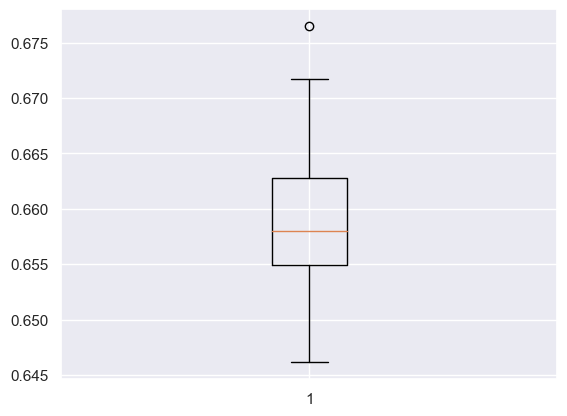

In [8]:
AUC_NumberOfCars = list()

for (i,data) in enumerate(DataSets):
    
    print("Starting i =",i)
    X_train, y_train, X_valid, y_valid = data

    r = {"a":'0 + C(NumberOfCars)'}
    mod = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
          C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_train)
    fit = mod.fit_vb()
    
    if i == 1:
        print(fit.summary())

    # Train dataset stuff
    params = fit.params
    exog_fixed = mod.exog
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
    
    ones = np.ones((exog_fixed.shape[0], mod.k_vcp))
    exog_variable = mod.exog_vc.toarray()
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
        print(exog_fixed.shape)
        print(ones.shape)
    
    XRand_train = np.hstack((exog_fixed,ones,exog_variable))
    
    if i == 1:
        print(XRand_train.shape)
    
    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_train))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)
    
    if i == 1:
        print(metrics.classification_report(y_train,y_pred))
    
    auc = metrics.roc_auc_score(y_train, y_pred_proba)

    if i == 1:
        print("Area under curve for train dataset is - ", auc)

    # Test Dataset stuff

    params = fit.params

    r = {"a":'0 + C(NumberOfCars)'}
    mod2 = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
         C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_valid)

    _ = mod2.fit_vb()

    exog_fixed = mod2.exog

    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp , mod2.k_vcp)

    ones = np.ones((exog_fixed.shape[0], mod2.k_vcp))
    exog_variable = mod2.exog_vc.toarray()

    if i == 1:
        print(exog_fixed.shape)
        print(ones.shape)

    XRand_valid = np.hstack((exog_fixed,ones,exog_variable))
    print(XRand_valid.shape)

    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_valid))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)

    if i == 1:
        print(metrics.classification_report(y_valid,y_pred))
        
    auc = metrics.roc_auc_score(y_valid, y_pred_proba)

    if i == 1:
        print("Area under curve is - ", auc)
    
    AUC_NumberOfCars.append(auc)

plt.figure()
plt.boxplot(AUC_NumberOfCars)

In [82]:
fp= open(r'./AUC_SMOTENumberOfCars.txt', 'w')
fp.write(str(AUC_NumberOfCars))
fp.close()


np.mean(AUC_NumberOfCars)

0.6592477194426731

# SMOTE Sampling - MultiLevel Modelling with PolicyType 

Starting i = 0
Area under curve for train dataset is -  0.8012661056658927
(11598, 59)
Starting i = 1
                             Binomial Mixed GLM Results
                                      Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
------------------------------------------------------------------------------------
Intercept                                M     0.7762   0.0183                      
C(NumberOfCars)[T.2 vehicles]            M     0.0894   0.0842                      
C(NumberOfCars)[T.3 to 4]                M     0.1869   0.1080                      
C(NumberOfCars)[T.5 to 8]                M     0.3774   0.4936                      
C(NumberOfCars)[T.more than 8]           M    -1.8827   1.4490                      
C(Fault)[T.Third Party]                  M    -2.6457   0.0584                      
VehiclePrice[T.30000 to 39000]           M     0.1678   0.0402                      
VehiclePrice[T.40000 to 59000]           M     0.5646   0.1052               

C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Number of V^2 parameters is -  1 1
(11598, 49)
(11598, 1)
(11598, 59)
              precision    recall  f1-score   support

           0       0.58      0.84      0.69      5870
           1       0.71      0.39      0.50      5728

    accuracy                           0.62     11598
   macro avg       0.65      0.61      0.60     11598
weighted avg       0.64      0.62      0.60     11598

Area under curve is -  0.6154308492667003
Starting i = 2
Area under curve for train dataset is -  0.8028685873419731
(11598, 59)
Starting i = 3
Area under curve for train dataset is -  0.800878697379674
(11598, 59)
Starting i = 4
Area under curve for train dataset is -  0.8004480571971803
(11598, 59)
Starting i = 5
Area under curve for train dataset is -  0.8036872372634544
(11598, 59)
Starting i = 6
Area under curve for train dataset is -  0.8023226466808803
(11598, 59)
Starting i = 7
Area under curve for train dataset is -  0.8030345883061746
(11598, 59)
Starting i = 8
Area under curve for trai

C:\Users\athimmas\Anaconda3\lib\site-packages\statsmodels\genmod\bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")


Area under curve for train dataset is -  0.8042737726817588
(11598, 59)
Starting i = 13
Area under curve for train dataset is -  0.8011501706876694
(11598, 59)
Starting i = 14
Area under curve for train dataset is -  0.8041195165699775
(11598, 59)
Starting i = 15
Area under curve for train dataset is -  0.8055408816501823
(11598, 59)
Starting i = 16
Area under curve for train dataset is -  0.8053611331941215
(11598, 59)
Starting i = 17
Area under curve for train dataset is -  0.8033547528509621
(11598, 59)
Starting i = 18
Area under curve for train dataset is -  0.8031276350323263
(11598, 59)
Starting i = 19
Area under curve for train dataset is -  0.7987007575912295
(11598, 59)


{'whiskers': [<matplotlib.lines.Line2D at 0x1c519864940>,
 'caps': [<matplotlib.lines.Line2D at 0x1c51987c280>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c5198647c0>],
 'medians': [<matplotlib.lines.Line2D at 0x1c51987c160>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c51987c5b0>],
 'means': []}

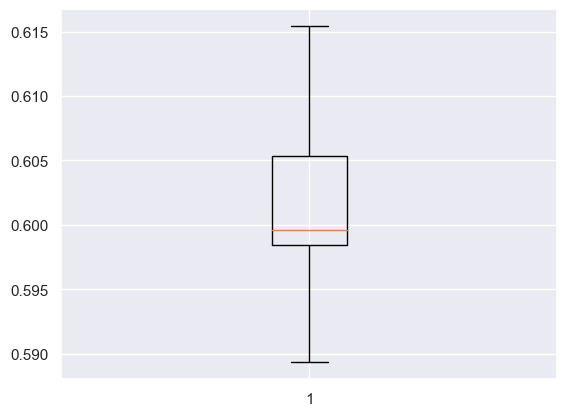

In [9]:
AUC_PolicyNumber = list()

for (i,data) in enumerate(DataSets):
    
    print("Starting i =",i)
    X_train, y_train, X_valid, y_valid = DataSets[i]

    r = {"a":'0 + C(PolicyType)'}
    mod = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
          C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_train)
    fit = mod.fit_vb()
    
    if i == 1:
        print(fit.summary())

    # Train dataset stuff
    params = fit.params
    exog_fixed = mod.exog
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
    
    ones = np.ones((exog_fixed.shape[0], mod.k_vcp))
    exog_variable = mod.exog_vc.toarray()
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
        print(exog_fixed.shape)
        print(ones.shape)
    
    XRand_train = np.hstack((exog_fixed,ones,exog_variable))
    
    if i == 1:
        print(XRand_train.shape)
    
    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_train))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)
    
    if i == 1:
        print(metrics.classification_report(y_train,y_pred))
    
    auc = metrics.roc_auc_score(y_train, y_pred_proba)

    if i == 1:
        print("Area under curve for train dataset is - ", auc)

    # Test Dataset stuff

    params = fit.params

    r = {"a":'0 + C(PolicyType)'}
    mod2 = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
         C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_valid)

    _ = mod2.fit_vb()

    exog_fixed = mod2.exog

    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp , mod2.k_vcp)

    ones = np.ones((exog_fixed.shape[0], mod2.k_vcp))
    exog_variable = mod2.exog_vc.toarray()

    if i == 1:
        print(exog_fixed.shape)
        print(ones.shape)

    XRand_valid = np.hstack((exog_fixed,ones,exog_variable))
    print(XRand_valid.shape)

    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_valid))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)

    if i == 1:
        print(metrics.classification_report(y_valid,y_pred))
        
    auc = metrics.roc_auc_score(y_valid, y_pred_proba)

    if i == 1:
        print("Area under curve is - ", auc)
    
    AUC_PolicyNumber.append(auc)

plt.figure()
plt.boxplot(AUC_PolicyNumber)

In [83]:
fp= open(r'./AUC_PolicyNumber.txt', 'w')
fp.write(str(AUC_PolicyNumber))
fp.close()


np.mean(AUC_PolicyNumber)

0.601364546850761

# SMOTE Sampling - MultiLevel Modelling with VehicleCategory 

Starting i = 0
Area under curve for train dataset is -  0.8012664096969625
(11598, 53)
Starting i = 1
                             Binomial Mixed GLM Results
                                      Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
------------------------------------------------------------------------------------
Intercept                                M     0.7746   0.0183                      
C(NumberOfCars)[T.2 vehicles]            M     0.0894   0.0842                      
C(NumberOfCars)[T.3 to 4]                M     0.1869   0.1080                      
C(NumberOfCars)[T.5 to 8]                M     0.3774   0.4936                      
C(NumberOfCars)[T.more than 8]           M    -1.8827   1.4490                      
C(Fault)[T.Third Party]                  M    -2.6455   0.0584                      
VehiclePrice[T.30000 to 39000]           M     0.1678   0.0402                      
VehiclePrice[T.40000 to 59000]           M     0.5646   0.1052               

{'whiskers': [<matplotlib.lines.Line2D at 0x1c5197f0460>,
 'caps': [<matplotlib.lines.Line2D at 0x1c5197f05b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c5197f0a30>],
 'medians': [<matplotlib.lines.Line2D at 0x1c5197f0940>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c5197ed100>],
 'means': []}

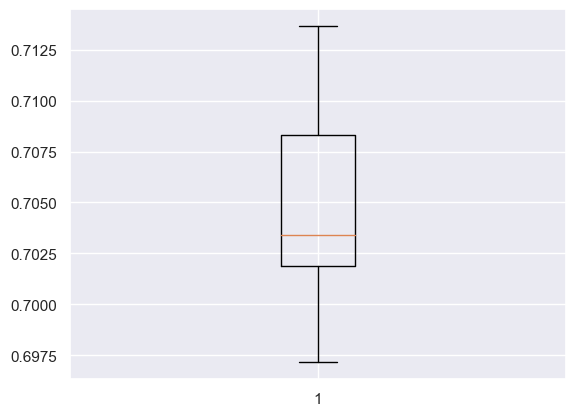

In [10]:
AUC_VehicleCategory = list()

for (i,data) in enumerate(DataSets):
    
    print("Starting i =",i)
    X_train, y_train, X_valid, y_valid = DataSets[i]

    r = {"a":'0 + C(VehicleCategory)'}
    mod = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
          C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_train)
    fit = mod.fit_vb()
    
    if i == 1:
        print(fit.summary())

    # Train dataset stuff
    params = fit.params
    exog_fixed = mod.exog
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
    
    ones = np.ones((exog_fixed.shape[0], mod.k_vcp))
    exog_variable = mod.exog_vc.toarray()
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
        print(exog_fixed.shape)
        print(ones.shape)
    
    XRand_train = np.hstack((exog_fixed,ones,exog_variable))
    
    if i == 1:
        print(XRand_train.shape)
    
    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_train))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)
    
    if i == 1:
        print(metrics.classification_report(y_train,y_pred))
    
    auc = metrics.roc_auc_score(y_train, y_pred_proba)

    if i == 1:
        print("Area under curve for train dataset is - ", auc)

    # Test Dataset stuff

    params = fit.params

    r = {"a":'0 + C(VehicleCategory)'}
    mod2 = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
         C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_valid)

    _ = mod2.fit_vb()

    exog_fixed = mod2.exog

    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp , mod2.k_vcp)

    ones = np.ones((exog_fixed.shape[0], mod2.k_vcp))
    exog_variable = mod2.exog_vc.toarray()

    if i == 1:
        print(exog_fixed.shape)
        print(ones.shape)

    XRand_valid = np.hstack((exog_fixed,ones,exog_variable))
    print(XRand_valid.shape)

    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_valid))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)

    if i == 1:
        print(metrics.classification_report(y_valid,y_pred))
        
    auc = metrics.roc_auc_score(y_valid, y_pred_proba)

    if i == 1:
        print("Area under curve is - ", auc)
    
    AUC_VehicleCategory.append(auc)
    
plt.figure()
plt.boxplot(AUC_VehicleCategory)

In [84]:
fp= open(r'./AUC_VehicleCategory.txt', 'w')
fp.write(str(AUC_VehicleCategory))
fp.close()

np.mean(AUC_VehicleCategory)

0.705064397192904

# SMOTE Sampling - MultiLevel Modelling with WitnessPresent 

Starting i = 0
Area under curve for train dataset is -  0.8012690534453971
(11598, 52)
Starting i = 1
                             Binomial Mixed GLM Results
                                      Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
------------------------------------------------------------------------------------
Intercept                                M     0.7685   0.0183                      
C(NumberOfCars)[T.2 vehicles]            M     0.0894   0.0842                      
C(NumberOfCars)[T.3 to 4]                M     0.1869   0.1080                      
C(NumberOfCars)[T.5 to 8]                M     0.3774   0.4936                      
C(NumberOfCars)[T.more than 8]           M    -1.8827   1.4490                      
C(Fault)[T.Third Party]                  M    -2.6455   0.0584                      
VehiclePrice[T.30000 to 39000]           M     0.1678   0.0402                      
VehiclePrice[T.40000 to 59000]           M     0.5645   0.1052               

{'whiskers': [<matplotlib.lines.Line2D at 0x1c5197399a0>,
 'caps': [<matplotlib.lines.Line2D at 0x1c5197c43a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c5198b2f40>],
 'medians': [<matplotlib.lines.Line2D at 0x1c51988b100>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c51988b3d0>],
 'means': []}

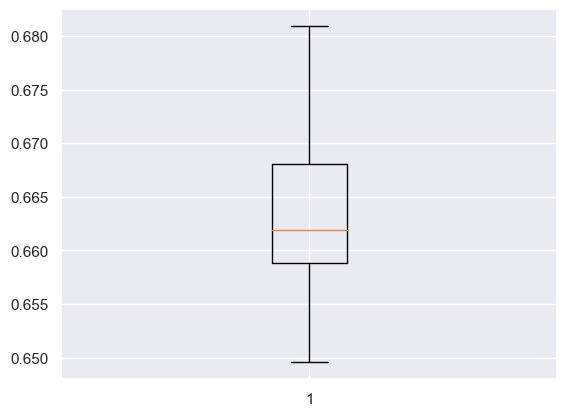

In [11]:
AUC_WitnessPresent = list()

for (i,data) in enumerate(DataSets):
    
    print("Starting i =", i)
    X_train, y_train, X_valid, y_valid = DataSets[i]

    r = {"a":'0 + C(WitnessPresent)'}
    mod = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
          C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_train)
    fit = mod.fit_vb()
    
    if i == 1:
        print(fit.summary())

    # Train dataset stuff
    params = fit.params
    exog_fixed = mod.exog
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
    
    ones = np.ones((exog_fixed.shape[0], mod.k_vcp))
    exog_variable = mod.exog_vc.toarray()
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
        print(exog_fixed.shape)
        print(ones.shape)
    
    XRand_train = np.hstack((exog_fixed,ones,exog_variable))
    
    if i == 1:
        print(XRand_train.shape)
    
    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_train))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)
    
    if i == 1:
        print(metrics.classification_report(y_train,y_pred))
    
    auc = metrics.roc_auc_score(y_train, y_pred_proba)

    if i == 1:
        print("Area under curve for train dataset is - ", auc)

    # Test Dataset stuff

    params = fit.params

    r = {"a":'0 + C(WitnessPresent)'}
    mod2 = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
         C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_valid)

    _ = mod2.fit_vb()

    exog_fixed = mod2.exog

    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp , mod2.k_vcp)

    ones = np.ones((exog_fixed.shape[0], mod2.k_vcp))
    exog_variable = mod2.exog_vc.toarray()

    if i == 1:
        print(exog_fixed.shape)
        print(ones.shape)

    XRand_valid = np.hstack((exog_fixed,ones,exog_variable))
    print(XRand_valid.shape)

    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_valid))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)

    if i == 1:
        print(metrics.classification_report(y_valid,y_pred))
        
    auc = metrics.roc_auc_score(y_valid, y_pred_proba)

    if i == 1:
        print("Area under curve is - ", auc)
    
    AUC_WitnessPresent.append(auc)
    
plt.boxplot(AUC_WitnessPresent)

In [85]:
fp= open(r'./AUC_WitnessPresent.txt', 'w')
fp.write(str(AUC_WitnessPresent))
fp.close()

np.mean(AUC_WitnessPresent)

0.6632132139679081

# SMOTE Sampling - MultiLevel Modelling with Make - 

Starting i = 0
Area under curve for train dataset is -  0.801269278164014
(11598, 67)
Starting i = 1
                             Binomial Mixed GLM Results
                                      Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
------------------------------------------------------------------------------------
Intercept                                M     0.7709   0.0183                      
C(NumberOfCars)[T.2 vehicles]            M     0.0894   0.0842                      
C(NumberOfCars)[T.3 to 4]                M     0.1870   0.1080                      
C(NumberOfCars)[T.5 to 8]                M     0.3774   0.4936                      
C(NumberOfCars)[T.more than 8]           M    -1.8828   1.4490                      
C(Fault)[T.Third Party]                  M    -2.6458   0.0584                      
VehiclePrice[T.30000 to 39000]           M     0.1678   0.0402                      
VehiclePrice[T.40000 to 59000]           M     0.5646   0.1052                

C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Number of V^2 parameters is -  1 1
(11598, 49)
(11598, 1)
(11598, 67)
              precision    recall  f1-score   support

           0       0.62      0.77      0.68      5870
           1       0.68      0.51      0.58      5728

    accuracy                           0.64     11598
   macro avg       0.65      0.64      0.63     11598
weighted avg       0.65      0.64      0.63     11598

Area under curve is -  0.6802722868862601
Starting i = 2
Area under curve for train dataset is -  0.8028715086839933
(11598, 67)
Starting i = 3
Area under curve for train dataset is -  0.8008962518692788
(11598, 67)
Starting i = 4
Area under curve for train dataset is -  0.8004432323562871
(11598, 67)
Starting i = 5
Area under curve for train dataset is -  0.8036764507698417
(11598, 67)
Starting i = 6
Area under curve for train dataset is -  0.8023356407044357
(11598, 67)
Starting i = 7
Area under curve for train dataset is -  0.8030355532743532
(11598, 67)
Starting i = 8
Area under curve for tra

{'whiskers': [<matplotlib.lines.Line2D at 0x1c51991a940>,
 'caps': [<matplotlib.lines.Line2D at 0x1c51991a2e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c51991a760>],
 'medians': [<matplotlib.lines.Line2D at 0x1c5199273d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c5199273a0>],
 'means': []}

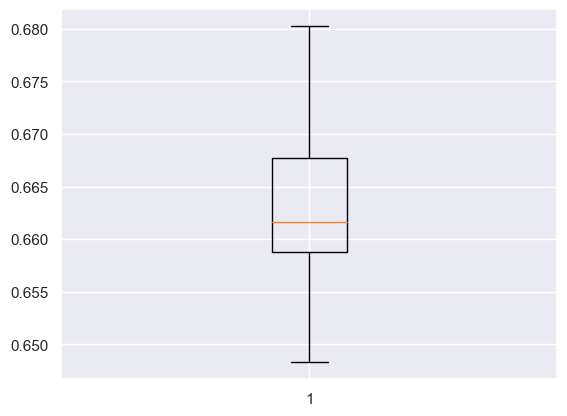

In [12]:
AUC_Make = list()

for (i,data) in enumerate(DataSets):
    
    print("Starting i =", i)
    X_train, y_train, X_valid, y_valid = DataSets[i]

    r = {"a":'0 + C(Make)'}
    mod = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
          C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_train)
    fit = mod.fit_vb()
    
    if i == 1:
        print(fit.summary())

    # Train dataset stuff
    params = fit.params
    exog_fixed = mod.exog
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
    
    ones = np.ones((exog_fixed.shape[0], mod.k_vcp))
    exog_variable = mod.exog_vc.toarray()
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
        print(exog_fixed.shape)
        print(ones.shape)
    
    XRand_train = np.hstack((exog_fixed,ones,exog_variable))
    
    if i == 1:
        print(XRand_train.shape)
    
    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_train))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)
    
    if i == 1:
        print(metrics.classification_report(y_train,y_pred))
    
    auc = metrics.roc_auc_score(y_train, y_pred_proba)

    if i == 1:
        print("Area under curve for train dataset is - ", auc)

    # Test Dataset stuff

    params = fit.params

    r = {"a":'0 + C(Make)'}
    mod2 = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
         C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_valid)

    _ = mod2.fit_vb()

    exog_fixed = mod2.exog

    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp , mod2.k_vcp)

    ones = np.ones((exog_fixed.shape[0], mod2.k_vcp))
    exog_variable = mod2.exog_vc.toarray()

    if i == 1:
        print(exog_fixed.shape)
        print(ones.shape)

    XRand_valid = np.hstack((exog_fixed,ones,exog_variable))
    print(XRand_valid.shape)

    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_valid))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)

    if i == 1:
        print(metrics.classification_report(y_valid,y_pred))
        
    auc = metrics.roc_auc_score(y_valid, y_pred_proba)

    if i == 1:
        print("Area under curve is - ", auc)
    
    AUC_Make.append(auc)
    
plt.boxplot(AUC_Make)

In [86]:
fp= open(r'./AUC_Make.txt', 'w')
fp.write(str(AUC_Make))
fp.close()

np.mean(AUC_Make)

0.6627337645613052

# SMOTE Sampling - MultiLevel Modelling with BasePolicy - 

Starting i = 0
Area under curve for train dataset is -  0.8012699391011225
(11598, 53)
Starting i = 1
                             Binomial Mixed GLM Results
                                      Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
------------------------------------------------------------------------------------
Intercept                                M     0.7775   0.0183                      
C(NumberOfCars)[T.2 vehicles]            M     0.0894   0.0842                      
C(NumberOfCars)[T.3 to 4]                M     0.1869   0.1080                      
C(NumberOfCars)[T.5 to 8]                M     0.3774   0.4936                      
C(NumberOfCars)[T.more than 8]           M    -1.8827   1.4490                      
C(Fault)[T.Third Party]                  M    -2.6456   0.0584                      
VehiclePrice[T.30000 to 39000]           M     0.1678   0.0402                      
VehiclePrice[T.40000 to 59000]           M     0.5646   0.1052               

{'whiskers': [<matplotlib.lines.Line2D at 0x1c5198c7f40>,
 'caps': [<matplotlib.lines.Line2D at 0x1c5198d8790>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c5199245e0>],
 'medians': [<matplotlib.lines.Line2D at 0x1c5198d8310>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c5198ee730>],
 'means': []}

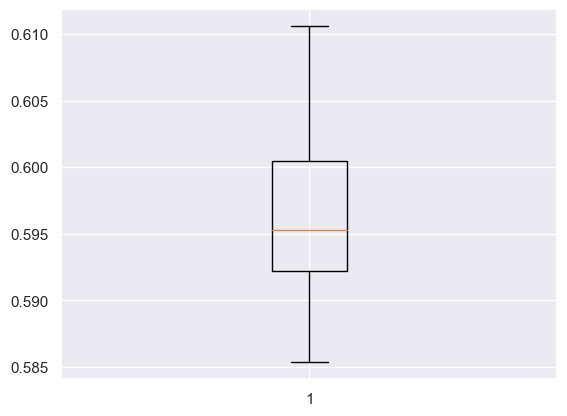

In [13]:
AUC_BasePolicy = list()

for (i,data) in enumerate(DataSets):
    
    print("Starting i =", i)
    X_train, y_train, X_valid, y_valid = DataSets[i]

    r = {"a":'0 + C(BasePolicy)'}
    mod = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
          C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_train)
    fit = mod.fit_vb()
    
    if i == 1:
        print(fit.summary())

    # Train dataset stuff
    params = fit.params
    exog_fixed = mod.exog
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
    
    ones = np.ones((exog_fixed.shape[0], mod.k_vcp))
    exog_variable = mod.exog_vc.toarray()
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
        print(exog_fixed.shape)
        print(ones.shape)
    
    XRand_train = np.hstack((exog_fixed,ones,exog_variable))
    
    if i == 1:
        print(XRand_train.shape)
    
    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_train))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)
    
    if i == 1:
        print(metrics.classification_report(y_train,y_pred))
    
    auc = metrics.roc_auc_score(y_train, y_pred_proba)

    if i == 1:
        print("Area under curve for train dataset is - ", auc)

    # Test Dataset stuff

    params = fit.params

    r = {"a":'0 + C(BasePolicy)'}
    mod2 = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
         C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_valid)

    _ = mod2.fit_vb()

    exog_fixed = mod2.exog

    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp , mod2.k_vcp)

    ones = np.ones((exog_fixed.shape[0], mod2.k_vcp))
    exog_variable = mod2.exog_vc.toarray()

    if i == 1:
        print(exog_fixed.shape)
        print(ones.shape)

    XRand_valid = np.hstack((exog_fixed,ones,exog_variable))
    print(XRand_valid.shape)

    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_valid))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)

    if i == 1:
        print(metrics.classification_report(y_valid,y_pred))
        
    auc = metrics.roc_auc_score(y_valid, y_pred_proba)

    if i == 1:
        print("Area under curve is - ", auc)
    
    AUC_BasePolicy.append(auc)
    
plt.boxplot(AUC_BasePolicy)

In [87]:
fp= open(r'./AUC_BasePolicy.txt', 'w')
fp.write(str(AUC_BasePolicy))
fp.close()

np.mean(AUC_BasePolicy)

0.5965304374696639

# SMOTE Sampling - MultiLevel Modelling with AgeOfVehicle

Starting i = 0
(11598, 58)
Starting i = 1
                             Binomial Mixed GLM Results
                                      Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
------------------------------------------------------------------------------------
Intercept                                M     0.7824   0.0183                      
C(NumberOfCars)[T.2 vehicles]            M     0.0894   0.0842                      
C(NumberOfCars)[T.3 to 4]                M     0.1869   0.1080                      
C(NumberOfCars)[T.5 to 8]                M     0.3774   0.4936                      
C(NumberOfCars)[T.more than 8]           M    -1.8827   1.4490                      
C(Fault)[T.Third Party]                  M    -2.6457   0.0584                      
VehiclePrice[T.30000 to 39000]           M     0.1678   0.0402                      
VehiclePrice[T.40000 to 59000]           M     0.5646   0.1052                      
VehiclePrice[T.60000 to 69000]           M     0.335

C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Number of V^2 parameters is -  1 1
(11598, 49)
(11598, 1)
(11598, 58)
              precision    recall  f1-score   support

           0       0.61      0.78      0.69      5870
           1       0.69      0.50      0.58      5728

    accuracy                           0.64     11598
   macro avg       0.65      0.64      0.63     11598
weighted avg       0.65      0.64      0.63     11598

Area under curve is -  0.6783502005748385
Starting i = 2
(11598, 58)
Starting i = 3
(11598, 58)
Starting i = 4
(11598, 58)
Starting i = 5
(11598, 58)
Starting i = 6
(11598, 58)
Starting i = 7
(11598, 58)
Starting i = 8
(11598, 58)
Starting i = 9
(11598, 58)
Starting i = 10
(11598, 58)
Starting i = 11
(11598, 58)
Starting i = 12
(11598, 58)
Starting i = 13
(11598, 58)
Starting i = 14
(11598, 58)
Starting i = 15
(11598, 58)
Starting i = 16
(11598, 58)
Starting i = 17
(11598, 58)
Starting i = 18
(11598, 58)
Starting i = 19
(11598, 58)


{'whiskers': [<matplotlib.lines.Line2D at 0x1c519927d90>,
 'caps': [<matplotlib.lines.Line2D at 0x1c519bc6280>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c5198d8bb0>],
 'medians': [<matplotlib.lines.Line2D at 0x1c519bc6820>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c519bc6af0>],
 'means': []}

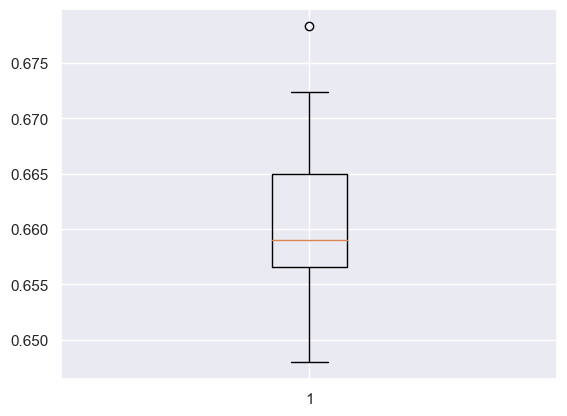

In [15]:
AUC_AgeOfVehicle = list()

for (i,data) in enumerate(DataSets):
    
    print("Starting i =", i)
    X_train, y_train, X_valid, y_valid = DataSets[i]

    r = {"a":'0 + C(AgeOfVehicle)'}
    mod = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
          C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_train)
    fit = mod.fit_vb()
    
    if i == 1:
        print(fit.summary())

    # Train dataset stuff
    params = fit.params
    exog_fixed = mod.exog
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
    
    ones = np.ones((exog_fixed.shape[0], mod.k_vcp))
    exog_variable = mod.exog_vc.toarray()
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
        print(exog_fixed.shape)
        print(ones.shape)
    
    XRand_train = np.hstack((exog_fixed,ones,exog_variable))
    
    if i == 1:
        print(XRand_train.shape)
    
    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_train))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)
    
    if i == 1:
        print(metrics.classification_report(y_train,y_pred))
    
    auc = metrics.roc_auc_score(y_train, y_pred_proba)

    if i == 1:
        print("Area under curve for train dataset is - ", auc)

    # Test Dataset stuff

    params = fit.params

    r = {"a":'0 + C(AgeOfVehicle)'}
    mod2 = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
         C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_valid)

    _ = mod2.fit_vb()

    exog_fixed = mod2.exog

    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp , mod2.k_vcp)

    ones = np.ones((exog_fixed.shape[0], mod2.k_vcp))
    exog_variable = mod2.exog_vc.toarray()

    if i == 1:
        print(exog_fixed.shape)
        print(ones.shape)

    XRand_valid = np.hstack((exog_fixed,ones,exog_variable))
    print(XRand_valid.shape)

    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_valid))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)

    if i == 1:
        print(metrics.classification_report(y_valid,y_pred))
        
    auc = metrics.roc_auc_score(y_valid, y_pred_proba)

    if i == 1:
        print("Area under curve is - ", auc)
    
    AUC_AgeOfVehicle.append(auc)
    
plt.boxplot(AUC_AgeOfVehicle)

In [88]:
fp= open(r'./AUC_AgeOfVehicle.txt', 'w')
fp.write(str(AUC_AgeOfVehicle))
fp.close()

np.mean(AUC_AgeOfVehicle)

0.6605178572278321

# SMOTE Borderline Sampling

In [16]:
# SMOTE Sampling 

X = DummiesData.drop(columns=['FraudFound_P'])
y = DummiesData['FraudFound_P']

counter = Counter(y)
print(counter)

BorderLineDataSets = list()

for i in range(20):
    over = BorderlineSMOTE(random_state=i)
    under = RandomUnderSampler(sampling_strategy=1)
    steps = [('o', over), ('u', under)]
    SMOTESampling = SamplingPipeline(steps=steps)

    X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)
    # summarize the new class distribution
    counter = Counter(y_resampled)
    
    if i == 1:
        print(counter)

    # Verifying un dummify works
    X_resampled = undummify(X_resampled)
    
    if i == 1:
        print(X_resampled.head())

    X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

    if i == 1:
        counter = Counter(y_train)
        print(counter)
        counter = Counter(y_valid)
        print(counter)

    X_train['FraudFound_P'] = y_train
    X_valid['FraudFound_P'] = y_valid

    #print(X_train.head())
    print(X_train.shape)
    
    BorderLineDataSets.append([X_train, y_train, X_valid, y_valid])

Counter({0: 14497, 1: 923})
(17396, 11)
Counter({0: 14497, 1: 14497})
  NumberOfCars          Fault     VehiclePrice VehicleCategory  \
0       3 to 4  Policy Holder  more than 69000           Sport   
1    1 vehicle  Policy Holder  more than 69000           Sport   
2    1 vehicle  Policy Holder  more than 69000           Sport   
3    1 vehicle    Third Party   20000 to 29000           Sport   
4    1 vehicle    Third Party  more than 69000           Sport   

          PolicyType WitnessPresent    Make BasePolicy AgeOfVehicle  \
0  Sport - Liability             No   Honda  Liability      3 years   
1  Sport - Collision             No   Honda  Collision      6 years   
2  Sport - Collision             No   Honda  Collision      7 years   
3  Sedan - Liability             No  Toyota  Liability  more than 7   
4  Sport - Collision             No   Honda  Collision      5 years   

  PastNumberOfClaims  
0               none  
1               none  
2                  1  
3             

In [17]:
len(BorderLineDataSets)

20

# Borderline Resampling - MultiLevel Modelling with NumberOfCars 

Starting i = 0
(11598, 54)
Starting i = 1
                             Binomial Mixed GLM Results
                                      Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
------------------------------------------------------------------------------------
Intercept                                M     0.6333   0.0188                      
C(NumberOfCars)[T.2 vehicles]            M    -0.1613   0.0863                      
C(NumberOfCars)[T.3 to 4]                M     0.1059   0.1092                      
C(NumberOfCars)[T.5 to 8]                M     0.7002   0.4813                      
C(NumberOfCars)[T.more than 8]           M    -1.8252   1.4711                      
C(Fault)[T.Third Party]                  M    -2.8553   0.0627                      
VehiclePrice[T.30000 to 39000]           M     0.3336   0.0414                      
VehiclePrice[T.40000 to 59000]           M     0.6031   0.1111                      
VehiclePrice[T.60000 to 69000]           M     0.914

{'whiskers': [<matplotlib.lines.Line2D at 0x1c51df34460>,
 'caps': [<matplotlib.lines.Line2D at 0x1c51df348e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c51df34190>],
 'medians': [<matplotlib.lines.Line2D at 0x1c51df34e80>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c51df4f190>],
 'means': []}

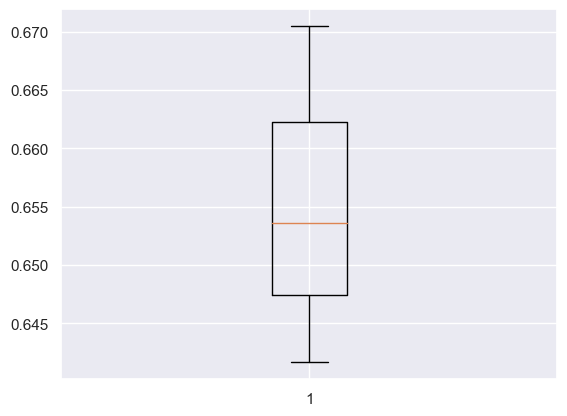

In [18]:
AUC_NumberOfCars_BorderlineSMOTE = list()

for (i,data) in enumerate(BorderLineDataSets):
    
    print("Starting i =",i)
    X_train, y_train, X_valid, y_valid = data

    r = {"a":'0 + C(NumberOfCars)'}
    mod = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
          C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_train)
    fit = mod.fit_vb()
    
    if i == 1:
        print(fit.summary())

    # Train dataset stuff
    params = fit.params
    exog_fixed = mod.exog
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
    
    ones = np.ones((exog_fixed.shape[0], mod.k_vcp))
    exog_variable = mod.exog_vc.toarray()
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
        print(exog_fixed.shape)
        print(ones.shape)
    
    XRand_train = np.hstack((exog_fixed,ones,exog_variable))
    
    if i == 1:
        print(XRand_train.shape)
    
    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_train))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)
    
    if i == 1:
        print(metrics.classification_report(y_train,y_pred))
    
    auc = metrics.roc_auc_score(y_train, y_pred_proba)

    if i == 1:
        print("Area under curve for train dataset is - ", auc)

    # Test Dataset stuff

    params = fit.params

    r = {"a":'0 + C(NumberOfCars)'}
    mod2 = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
         C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_valid)

    _ = mod2.fit_vb()

    exog_fixed = mod2.exog

    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp , mod2.k_vcp)

    ones = np.ones((exog_fixed.shape[0], mod2.k_vcp))
    exog_variable = mod2.exog_vc.toarray()

    if i == 1:
        print(exog_fixed.shape)
        print(ones.shape)

    XRand_valid = np.hstack((exog_fixed,ones,exog_variable))
    print(XRand_valid.shape)

    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_valid))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)

    if i == 1:
        print(metrics.classification_report(y_valid,y_pred))
        
    auc = metrics.roc_auc_score(y_valid, y_pred_proba)

    if i == 1:
        print("Area under curve is - ", auc)
    
    AUC_NumberOfCars_BorderlineSMOTE.append(auc)

plt.figure()
plt.boxplot(AUC_NumberOfCars_BorderlineSMOTE)

In [89]:
fp= open(r'./AUC_NumberOfCars_BorderlineSMOTE.txt', 'w')
fp.write(str(AUC_NumberOfCars_BorderlineSMOTE))
fp.close()


np.mean(AUC_NumberOfCars_BorderlineSMOTE)

0.6545101173707804

# Borderline Resampling - MultiLevel Modelling with PolicyType 

Starting i = 0
(11598, 59)
Starting i = 1
                             Binomial Mixed GLM Results
                                      Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
------------------------------------------------------------------------------------
Intercept                                M     0.6343   0.0188                      
C(NumberOfCars)[T.2 vehicles]            M    -0.1672   0.0863                      
C(NumberOfCars)[T.3 to 4]                M     0.1005   0.1092                      
C(NumberOfCars)[T.5 to 8]                M     0.6959   0.4812                      
C(NumberOfCars)[T.more than 8]           M    -1.8291   1.4705                      
C(Fault)[T.Third Party]                  M    -2.8555   0.0627                      
VehiclePrice[T.30000 to 39000]           M     0.3336   0.0414                      
VehiclePrice[T.40000 to 59000]           M     0.6031   0.1111                      
VehiclePrice[T.60000 to 69000]           M     0.914

{'whiskers': [<matplotlib.lines.Line2D at 0x1c51c30e400>,
 'caps': [<matplotlib.lines.Line2D at 0x1c51b4daac0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c5199da790>],
 'medians': [<matplotlib.lines.Line2D at 0x1c51b4dac70>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c51b4d5a30>],
 'means': []}

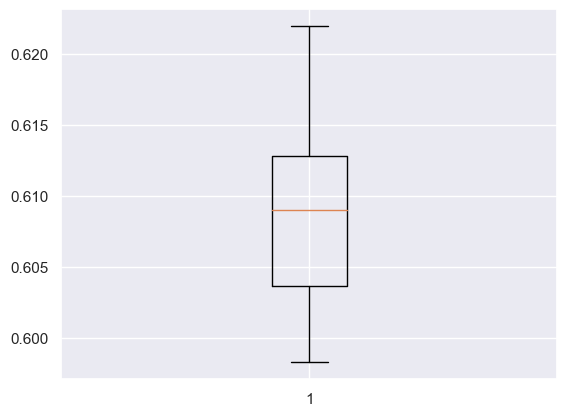

In [19]:
AUC_PolicyType_BorderlineSMOTE = list()

for (i,data) in enumerate(BorderLineDataSets):
    
    print("Starting i =",i)
    X_train, y_train, X_valid, y_valid = data

    r = {"a":'0 + C(PolicyType)'}
    mod = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
          C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_train)
    fit = mod.fit_vb()
    
    if i == 1:
        print(fit.summary())

    # Train dataset stuff
    params = fit.params
    exog_fixed = mod.exog
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
    
    ones = np.ones((exog_fixed.shape[0], mod.k_vcp))
    exog_variable = mod.exog_vc.toarray()
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
        print(exog_fixed.shape)
        print(ones.shape)
    
    XRand_train = np.hstack((exog_fixed,ones,exog_variable))
    
    if i == 1:
        print(XRand_train.shape)
    
    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_train))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)
    
    if i == 1:
        print(metrics.classification_report(y_train,y_pred))
    
    auc = metrics.roc_auc_score(y_train, y_pred_proba)

    if i == 1:
        print("Area under curve for train dataset is - ", auc)

    # Test Dataset stuff

    params = fit.params

    r = {"a":'0 + C(PolicyType)'}
    mod2 = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
         C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_valid)

    _ = mod2.fit_vb()

    exog_fixed = mod2.exog

    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp , mod2.k_vcp)

    ones = np.ones((exog_fixed.shape[0], mod2.k_vcp))
    exog_variable = mod2.exog_vc.toarray()

    if i == 1:
        print(exog_fixed.shape)
        print(ones.shape)

    XRand_valid = np.hstack((exog_fixed,ones,exog_variable))
    print(XRand_valid.shape)

    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_valid))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)

    if i == 1:
        print(metrics.classification_report(y_valid,y_pred))
        
    auc = metrics.roc_auc_score(y_valid, y_pred_proba)

    if i == 1:
        print("Area under curve is - ", auc)
    
    AUC_PolicyType_BorderlineSMOTE.append(auc)

plt.figure()
plt.boxplot(AUC_PolicyType_BorderlineSMOTE)

In [90]:
fp= open(r'./AUC_PolicyType_BorderlineSMOTE.txt', 'w')
fp.write(str(AUC_PolicyType_BorderlineSMOTE))
fp.close()


np.mean(AUC_PolicyType_BorderlineSMOTE)

0.6088312113958867

# Borderline Resampling - MultiLevel Modelling with VehicleCategory 

Starting i = 0
(11598, 53)
Starting i = 1
                             Binomial Mixed GLM Results
                                      Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
------------------------------------------------------------------------------------
Intercept                                M     0.6327   0.0188                      
C(NumberOfCars)[T.2 vehicles]            M    -0.1672   0.0863                      
C(NumberOfCars)[T.3 to 4]                M     0.1005   0.1092                      
C(NumberOfCars)[T.5 to 8]                M     0.6959   0.4812                      
C(NumberOfCars)[T.more than 8]           M    -1.8291   1.4705                      
C(Fault)[T.Third Party]                  M    -2.8553   0.0627                      
VehiclePrice[T.30000 to 39000]           M     0.3336   0.0414                      
VehiclePrice[T.40000 to 59000]           M     0.6031   0.1111                      
VehiclePrice[T.60000 to 69000]           M     0.914

{'whiskers': [<matplotlib.lines.Line2D at 0x1c51b4dce80>,
 'caps': [<matplotlib.lines.Line2D at 0x1c51b4dc6d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c51b58f8b0>],
 'medians': [<matplotlib.lines.Line2D at 0x1c51b4dce20>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c51b4dcdf0>],
 'means': []}

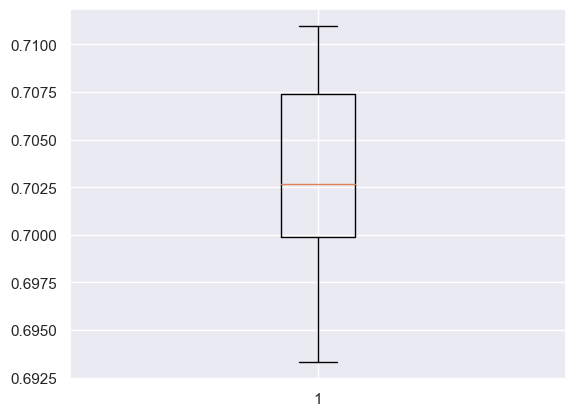

In [20]:
AUC_VehicleCategory_BorderlineSMOTE = list()

for (i,data) in enumerate(BorderLineDataSets):
    
    print("Starting i =",i)
    X_train, y_train, X_valid, y_valid = data

    r = {"a":'0 + C(VehicleCategory)'}
    mod = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
          C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_train)
    fit = mod.fit_vb()
    
    if i == 1:
        print(fit.summary())

    # Train dataset stuff
    params = fit.params
    exog_fixed = mod.exog
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
    
    ones = np.ones((exog_fixed.shape[0], mod.k_vcp))
    exog_variable = mod.exog_vc.toarray()
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
        print(exog_fixed.shape)
        print(ones.shape)
    
    XRand_train = np.hstack((exog_fixed,ones,exog_variable))
    
    if i == 1:
        print(XRand_train.shape)
    
    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_train))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)
    
    if i == 1:
        print(metrics.classification_report(y_train,y_pred))
    
    auc = metrics.roc_auc_score(y_train, y_pred_proba)

    if i == 1:
        print("Area under curve for train dataset is - ", auc)

    # Test Dataset stuff

    params = fit.params

    r = {"a":'0 + C(VehicleCategory)'}
    mod2 = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
         C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_valid)

    _ = mod2.fit_vb()

    exog_fixed = mod2.exog

    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp , mod2.k_vcp)

    ones = np.ones((exog_fixed.shape[0], mod2.k_vcp))
    exog_variable = mod2.exog_vc.toarray()

    if i == 1:
        print(exog_fixed.shape)
        print(ones.shape)

    XRand_valid = np.hstack((exog_fixed,ones,exog_variable))
    print(XRand_valid.shape)

    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_valid))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)

    if i == 1:
        print(metrics.classification_report(y_valid,y_pred))
        
    auc = metrics.roc_auc_score(y_valid, y_pred_proba)

    if i == 1:
        print("Area under curve is - ", auc)
    
    AUC_VehicleCategory_BorderlineSMOTE.append(auc)

plt.figure()
plt.boxplot(AUC_VehicleCategory_BorderlineSMOTE)

In [91]:
fp= open(r'./AUC_VehicleCategory_BorderlineSMOTE.txt', 'w')
fp.write(str(AUC_VehicleCategory_BorderlineSMOTE))
fp.close()

np.mean(AUC_VehicleCategory_BorderlineSMOTE)

0.702850860235265

# Borderline Resampling - MultiLevel Modelling with WitnessPresent 

Starting i = 0
(11598, 52)
Starting i = 1
                             Binomial Mixed GLM Results
                                      Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
------------------------------------------------------------------------------------
Intercept                                M     0.6297   0.0188                      
C(NumberOfCars)[T.2 vehicles]            M    -0.1672   0.0863                      
C(NumberOfCars)[T.3 to 4]                M     0.1005   0.1092                      
C(NumberOfCars)[T.5 to 8]                M     0.6959   0.4812                      
C(NumberOfCars)[T.more than 8]           M    -1.8291   1.4705                      
C(Fault)[T.Third Party]                  M    -2.8552   0.0627                      
VehiclePrice[T.30000 to 39000]           M     0.3336   0.0414                      
VehiclePrice[T.40000 to 59000]           M     0.6031   0.1111                      
VehiclePrice[T.60000 to 69000]           M     0.914

{'whiskers': [<matplotlib.lines.Line2D at 0x1c51b5ac2b0>,
 'caps': [<matplotlib.lines.Line2D at 0x1c51b5acc10>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c51b5ac7f0>],
 'medians': [<matplotlib.lines.Line2D at 0x1c51b5acb20>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c51b596250>],
 'means': []}

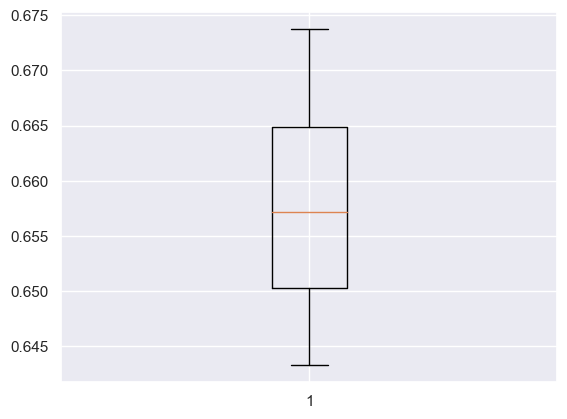

In [21]:
AUC_WitnessPresent_BorderlineSMOTE = list()

for (i,data) in enumerate(BorderLineDataSets):
    
    print("Starting i =",i)
    X_train, y_train, X_valid, y_valid = data

    r = {"a":'0 + C(WitnessPresent)'}
    mod = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
          C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_train)
    fit = mod.fit_vb()
    
    if i == 1:
        print(fit.summary())

    # Train dataset stuff
    params = fit.params
    exog_fixed = mod.exog
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
    
    ones = np.ones((exog_fixed.shape[0], mod.k_vcp))
    exog_variable = mod.exog_vc.toarray()
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
        print(exog_fixed.shape)
        print(ones.shape)
    
    XRand_train = np.hstack((exog_fixed,ones,exog_variable))
    
    if i == 1:
        print(XRand_train.shape)
    
    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_train))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)
    
    if i == 1:
        print(metrics.classification_report(y_train,y_pred))
    
    auc = metrics.roc_auc_score(y_train, y_pred_proba)

    if i == 1:
        print("Area under curve for train dataset is - ", auc)

    # Test Dataset stuff

    params = fit.params

    r = {"a":'0 + C(WitnessPresent)'}
    mod2 = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
         C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_valid)

    _ = mod2.fit_vb()

    exog_fixed = mod2.exog

    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp , mod2.k_vcp)

    ones = np.ones((exog_fixed.shape[0], mod2.k_vcp))
    exog_variable = mod2.exog_vc.toarray()

    if i == 1:
        print(exog_fixed.shape)
        print(ones.shape)

    XRand_valid = np.hstack((exog_fixed,ones,exog_variable))
    print(XRand_valid.shape)

    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_valid))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)

    if i == 1:
        print(metrics.classification_report(y_valid,y_pred))
        
    auc = metrics.roc_auc_score(y_valid, y_pred_proba)

    if i == 1:
        print("Area under curve is - ", auc)
    
    AUC_WitnessPresent_BorderlineSMOTE.append(auc)

plt.figure()
plt.boxplot(AUC_WitnessPresent_BorderlineSMOTE)

In [92]:
fp= open(r'./AUC_WitnessPresent_BorderlineSMOTE.txt', 'w')
fp.write(str(AUC_WitnessPresent_BorderlineSMOTE))
fp.close()

np.mean(AUC_WitnessPresent_BorderlineSMOTE)

0.6576744367606329

# Borderline Resampling - MultiLevel Modelling with Make - 

Starting i = 0
(11598, 67)
Starting i = 1
                             Binomial Mixed GLM Results
                                      Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
------------------------------------------------------------------------------------
Intercept                                M     0.6296   0.0188                      
C(NumberOfCars)[T.2 vehicles]            M    -0.1672   0.0863                      
C(NumberOfCars)[T.3 to 4]                M     0.1006   0.1092                      
C(NumberOfCars)[T.5 to 8]                M     0.6959   0.4812                      
C(NumberOfCars)[T.more than 8]           M    -1.8292   1.4705                      
C(Fault)[T.Third Party]                  M    -2.8556   0.0627                      
VehiclePrice[T.30000 to 39000]           M     0.3336   0.0414                      
VehiclePrice[T.40000 to 59000]           M     0.6032   0.1111                      
VehiclePrice[T.60000 to 69000]           M     0.914

C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Number of V^2 parameters is -  1 1
(11598, 49)
(11598, 1)
(11598, 67)
              precision    recall  f1-score   support

           0       0.61      0.75      0.67      5870
           1       0.66      0.51      0.58      5728

    accuracy                           0.63     11598
   macro avg       0.64      0.63      0.63     11598
weighted avg       0.64      0.63      0.63     11598

Area under curve is -  0.655553415839464
Starting i = 2
(11598, 67)
Starting i = 3
(11598, 67)
Starting i = 4
(11598, 67)
Starting i = 5
(11598, 67)
Starting i = 6
(11598, 67)
Starting i = 7
(11598, 67)
Starting i = 8
(11598, 67)
Starting i = 9
(11598, 67)
Starting i = 10
(11598, 67)
Starting i = 11
(11598, 67)
Starting i = 12
(11598, 67)
Starting i = 13
(11598, 67)
Starting i = 14
(11598, 67)
Starting i = 15
(11598, 67)
Starting i = 16
(11598, 67)
Starting i = 17


C:\Users\athimmas\Anaconda3\lib\site-packages\statsmodels\genmod\bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")


(11598, 67)
Starting i = 18
(11598, 67)
Starting i = 19
(11598, 67)


{'whiskers': [<matplotlib.lines.Line2D at 0x1c51b5b1730>,
 'caps': [<matplotlib.lines.Line2D at 0x1c51b51b2b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c51b5b1b20>],
 'medians': [<matplotlib.lines.Line2D at 0x1c51b51b850>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c51b51bb20>],
 'means': []}

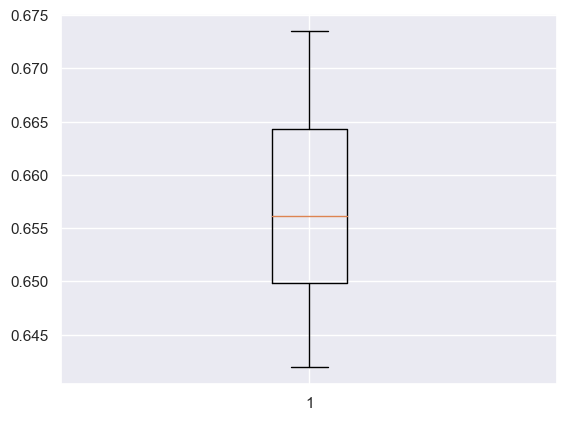

In [22]:
AUC_Make_BorderlineSMOTE = list()

for (i,data) in enumerate(BorderLineDataSets):
    
    print("Starting i =",i)
    X_train, y_train, X_valid, y_valid = data

    r = {"a":'0 + C(Make)'}
    mod = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
          C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_train)
    fit = mod.fit_vb()
    
    if i == 1:
        print(fit.summary())

    # Train dataset stuff
    params = fit.params
    exog_fixed = mod.exog
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
    
    ones = np.ones((exog_fixed.shape[0], mod.k_vcp))
    exog_variable = mod.exog_vc.toarray()
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
        print(exog_fixed.shape)
        print(ones.shape)
    
    XRand_train = np.hstack((exog_fixed,ones,exog_variable))
    
    if i == 1:
        print(XRand_train.shape)
    
    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_train))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)
    
    if i == 1:
        print(metrics.classification_report(y_train,y_pred))
    
    auc = metrics.roc_auc_score(y_train, y_pred_proba)

    if i == 1:
        print("Area under curve for train dataset is - ", auc)

    # Test Dataset stuff

    params = fit.params

    r = {"a":'0 + C(Make)'}
    mod2 = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
         C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_valid)

    _ = mod2.fit_vb()

    exog_fixed = mod2.exog

    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp , mod2.k_vcp)

    ones = np.ones((exog_fixed.shape[0], mod2.k_vcp))
    exog_variable = mod2.exog_vc.toarray()

    if i == 1:
        print(exog_fixed.shape)
        print(ones.shape)

    XRand_valid = np.hstack((exog_fixed,ones,exog_variable))
    print(XRand_valid.shape)

    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_valid))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)

    if i == 1:
        print(metrics.classification_report(y_valid,y_pred))
        
    auc = metrics.roc_auc_score(y_valid, y_pred_proba)

    if i == 1:
        print("Area under curve is - ", auc)
    
    AUC_Make_BorderlineSMOTE.append(auc)

plt.figure()
plt.boxplot(AUC_Make_BorderlineSMOTE)

In [94]:
fp= open(r'./AUC_Make_BorderlineSMOTE.txt', 'w')
fp.write(str(AUC_Make_BorderlineSMOTE))
fp.close()


np.mean(AUC_Make_BorderlineSMOTE)

0.6569575066263457

# Borderline Resampling - MultiLevel Modelling with BasePolicy

Starting i = 0
(11598, 53)
Starting i = 1
                             Binomial Mixed GLM Results
                                      Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
------------------------------------------------------------------------------------
Intercept                                M     0.6354   0.0188                      
C(NumberOfCars)[T.2 vehicles]            M    -0.1672   0.0863                      
C(NumberOfCars)[T.3 to 4]                M     0.1005   0.1092                      
C(NumberOfCars)[T.5 to 8]                M     0.6959   0.4812                      
C(NumberOfCars)[T.more than 8]           M    -1.8291   1.4705                      
C(Fault)[T.Third Party]                  M    -2.8553   0.0627                      
VehiclePrice[T.30000 to 39000]           M     0.3336   0.0414                      
VehiclePrice[T.40000 to 59000]           M     0.6031   0.1111                      
VehiclePrice[T.60000 to 69000]           M     0.914

{'whiskers': [<matplotlib.lines.Line2D at 0x1c51b706700>,
 'caps': [<matplotlib.lines.Line2D at 0x1c51b706ca0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c51b706430>],
 'medians': [<matplotlib.lines.Line2D at 0x1c51b6f3280>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c51b6f3550>],
 'means': []}

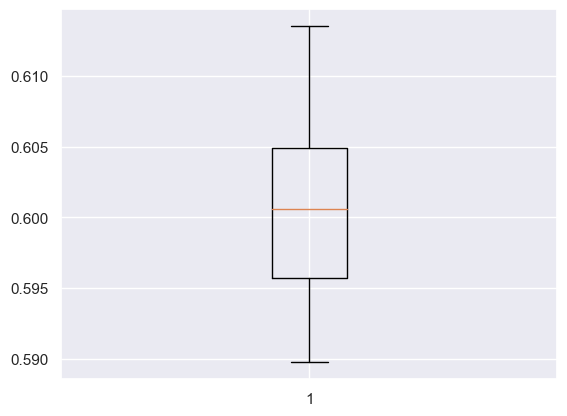

In [23]:
AUC_BasePolicy_BorderlineSMOTE = list()

for (i,data) in enumerate(BorderLineDataSets):
    
    print("Starting i =",i)
    X_train, y_train, X_valid, y_valid = data

    r = {"a":'0 + C(BasePolicy)'}
    mod = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
          C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_train)
    fit = mod.fit_vb()
    
    if i == 1:
        print(fit.summary())

    # Train dataset stuff
    params = fit.params
    exog_fixed = mod.exog
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
    
    ones = np.ones((exog_fixed.shape[0], mod.k_vcp))
    exog_variable = mod.exog_vc.toarray()
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
        print(exog_fixed.shape)
        print(ones.shape)
    
    XRand_train = np.hstack((exog_fixed,ones,exog_variable))
    
    if i == 1:
        print(XRand_train.shape)
    
    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_train))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)
    
    if i == 1:
        print(metrics.classification_report(y_train,y_pred))
    
    auc = metrics.roc_auc_score(y_train, y_pred_proba)

    if i == 1:
        print("Area under curve for train dataset is - ", auc)

    # Test Dataset stuff

    params = fit.params

    r = {"a":'0 + C(BasePolicy)'}
    mod2 = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
         C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_valid)

    _ = mod2.fit_vb()

    exog_fixed = mod2.exog

    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp , mod2.k_vcp)

    ones = np.ones((exog_fixed.shape[0], mod2.k_vcp))
    exog_variable = mod2.exog_vc.toarray()

    if i == 1:
        print(exog_fixed.shape)
        print(ones.shape)

    XRand_valid = np.hstack((exog_fixed,ones,exog_variable))
    print(XRand_valid.shape)

    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_valid))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)

    if i == 1:
        print(metrics.classification_report(y_valid,y_pred))
        
    auc = metrics.roc_auc_score(y_valid, y_pred_proba)

    if i == 1:
        print("Area under curve is - ", auc)
    
    AUC_BasePolicy_BorderlineSMOTE.append(auc)

plt.figure()
plt.boxplot(AUC_BasePolicy_BorderlineSMOTE)

In [95]:
fp= open(r'./AUC_BasePolicy_BorderlineSMOTE.txt', 'w')
fp.write(str(AUC_BasePolicy_BorderlineSMOTE))
fp.close()

np.mean(AUC_BasePolicy_BorderlineSMOTE)

0.6008156591131879

# Borderline Resampling - MultiLevel Modelling with AgeOfVehicle - 

Starting i = 0
(11598, 58)
Starting i = 1
                             Binomial Mixed GLM Results
                                      Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
------------------------------------------------------------------------------------
Intercept                                M     0.6420   0.0188                      
C(NumberOfCars)[T.2 vehicles]            M    -0.1672   0.0863                      
C(NumberOfCars)[T.3 to 4]                M     0.1005   0.1092                      
C(NumberOfCars)[T.5 to 8]                M     0.6959   0.4812                      
C(NumberOfCars)[T.more than 8]           M    -1.8292   1.4705                      
C(Fault)[T.Third Party]                  M    -2.8555   0.0627                      
VehiclePrice[T.30000 to 39000]           M     0.3337   0.0414                      
VehiclePrice[T.40000 to 59000]           M     0.6032   0.1111                      
VehiclePrice[T.60000 to 69000]           M     0.914

{'whiskers': [<matplotlib.lines.Line2D at 0x1c51b5f4130>,
 'caps': [<matplotlib.lines.Line2D at 0x1c51b600b50>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c51b5f4160>],
 'medians': [<matplotlib.lines.Line2D at 0x1c51b600550>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c51b600bb0>],
 'means': []}

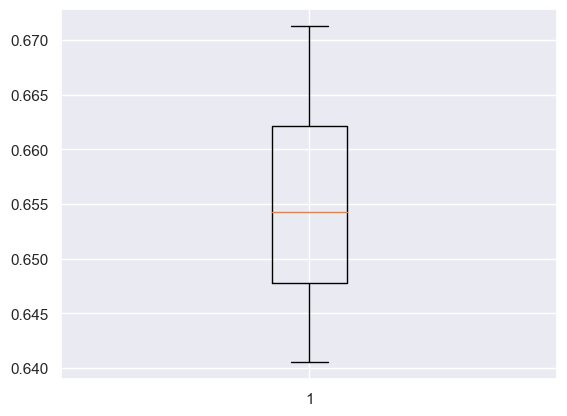

In [24]:
AUC_AgeOfVehicle_BorderlineSMOTE = list()

for (i,data) in enumerate(BorderLineDataSets):
    
    print("Starting i =",i)
    X_train, y_train, X_valid, y_valid = data

    r = {"a":'0 + C(AgeOfVehicle)'}
    mod = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
          C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_train)
    fit = mod.fit_vb()
    
    if i == 1:
        print(fit.summary())

    # Train dataset stuff
    params = fit.params
    exog_fixed = mod.exog
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
    
    ones = np.ones((exog_fixed.shape[0], mod.k_vcp))
    exog_variable = mod.exog_vc.toarray()
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
        print(exog_fixed.shape)
        print(ones.shape)
    
    XRand_train = np.hstack((exog_fixed,ones,exog_variable))
    
    if i == 1:
        print(XRand_train.shape)
    
    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_train))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)
    
    if i == 1:
        print(metrics.classification_report(y_train,y_pred))
    
    auc = metrics.roc_auc_score(y_train, y_pred_proba)

    if i == 1:
        print("Area under curve for train dataset is - ", auc)

    # Test Dataset stuff

    params = fit.params

    r = {"a":'0 + C(AgeOfVehicle)'}
    mod2 = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
         C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_valid)

    _ = mod2.fit_vb()

    exog_fixed = mod2.exog

    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp , mod2.k_vcp)

    ones = np.ones((exog_fixed.shape[0], mod2.k_vcp))
    exog_variable = mod2.exog_vc.toarray()

    if i == 1:
        print(exog_fixed.shape)
        print(ones.shape)

    XRand_valid = np.hstack((exog_fixed,ones,exog_variable))
    print(XRand_valid.shape)

    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_valid))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)

    if i == 1:
        print(metrics.classification_report(y_valid,y_pred))
        
    auc = metrics.roc_auc_score(y_valid, y_pred_proba)

    if i == 1:
        print("Area under curve is - ", auc)
    
    AUC_AgeOfVehicle_BorderlineSMOTE.append(auc)

plt.figure()
plt.boxplot(AUC_AgeOfVehicle_BorderlineSMOTE)

In [96]:
fp= open(r'./AUC_AgeOfVehicle_BorderlineSMOTE.txt', 'w')
fp.write(str(AUC_AgeOfVehicle_BorderlineSMOTE))
fp.close()

np.mean(AUC_AgeOfVehicle_BorderlineSMOTE)

0.6548845921407023

# SVM Resampling

In [25]:
# SMOTE Sampling 

X = DummiesData.drop(columns=['FraudFound_P'])
y = DummiesData['FraudFound_P']

counter = Counter(y)
print(counter)

SVMDataSets = list()

for i in range(20):
    over = SVMSMOTE(random_state=i)
    under = RandomUnderSampler(sampling_strategy=1)
    steps = [('o', over), ('u', under)]
    SMOTESampling = SamplingPipeline(steps=steps)

    X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)
    # summarize the new class distribution
    counter = Counter(y_resampled)
    
    if i == 1:
        print(counter)

    # Verifying un dummify works
    X_resampled = undummify(X_resampled)
    
    if i == 1:
        print(X_resampled.head())

    X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

    if i == 1:
        counter = Counter(y_train)
        print(counter)
        counter = Counter(y_valid)
        print(counter)

    X_train['FraudFound_P'] = y_train
    X_valid['FraudFound_P'] = y_valid

    #print(X_train.head())
    print(X_train.shape)
    
    SVMDataSets.append([X_train, y_train, X_valid, y_valid])

Counter({0: 14497, 1: 923})
(17396, 11)
Counter({0: 14497, 1: 14497})
  NumberOfCars          Fault     VehiclePrice VehicleCategory  \
0       3 to 4  Policy Holder  more than 69000           Sport   
1    1 vehicle  Policy Holder  more than 69000           Sport   
2    1 vehicle  Policy Holder  more than 69000           Sport   
3    1 vehicle    Third Party   20000 to 29000           Sport   
4    1 vehicle    Third Party  more than 69000           Sport   

          PolicyType WitnessPresent    Make BasePolicy AgeOfVehicle  \
0  Sport - Liability             No   Honda  Liability      3 years   
1  Sport - Collision             No   Honda  Collision      6 years   
2  Sport - Collision             No   Honda  Collision      7 years   
3  Sedan - Liability             No  Toyota  Liability  more than 7   
4  Sport - Collision             No   Honda  Collision      5 years   

  PastNumberOfClaims  
0               none  
1               none  
2                  1  
3             

# SVM Resampling - MultiLevel Modelling with NumberOfCars

Starting i = 0
(11598, 54)
Starting i = 1
                             Binomial Mixed GLM Results
                                      Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
------------------------------------------------------------------------------------
Intercept                                M     0.5973   0.0202                      
C(NumberOfCars)[T.2 vehicles]            M    -0.2355   0.0962                      
C(NumberOfCars)[T.3 to 4]                M     0.0397   0.1223                      
C(NumberOfCars)[T.5 to 8]                M     0.0608   0.6281                      
C(NumberOfCars)[T.more than 8]           M    -2.0003   1.4906                      
C(Fault)[T.Third Party]                  M    -3.1453   0.0779                      
VehiclePrice[T.30000 to 39000]           M     0.3752   0.0453                      
VehiclePrice[T.40000 to 59000]           M     0.7228   0.1209                      
VehiclePrice[T.60000 to 69000]           M     0.799

{'whiskers': [<matplotlib.lines.Line2D at 0x1c539770040>,
 'caps': [<matplotlib.lines.Line2D at 0x1c5197357c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c5397702b0>],
 'medians': [<matplotlib.lines.Line2D at 0x1c5197e9d60>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c51b4bb070>],
 'means': []}

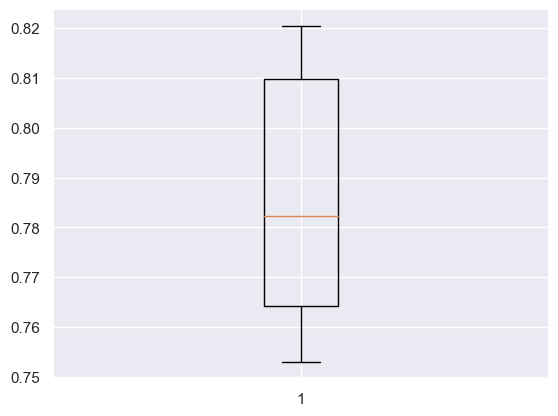

In [26]:
AUC_NumberOfCars_SVMSMOTE = list()

for (i,data) in enumerate(SVMDataSets):
    
    print("Starting i =",i)
    X_train, y_train, X_valid, y_valid = data

    r = {"a":'0 + C(NumberOfCars)'}
    mod = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
          C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_train)
    fit = mod.fit_vb()
    
    if i == 1:
        print(fit.summary())

    # Train dataset stuff
    params = fit.params
    exog_fixed = mod.exog
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
    
    ones = np.ones((exog_fixed.shape[0], mod.k_vcp))
    exog_variable = mod.exog_vc.toarray()
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
        print(exog_fixed.shape)
        print(ones.shape)
    
    XRand_train = np.hstack((exog_fixed,ones,exog_variable))
    
    if i == 1:
        print(XRand_train.shape)
    
    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_train))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)
    
    if i == 1:
        print(metrics.classification_report(y_train,y_pred))
    
    auc = metrics.roc_auc_score(y_train, y_pred_proba)

    if i == 1:
        print("Area under curve for train dataset is - ", auc)

    # Test Dataset stuff

    params = fit.params

    r = {"a":'0 + C(NumberOfCars)'}
    mod2 = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
         C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_valid)

    _ = mod2.fit_vb()

    exog_fixed = mod2.exog

    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp , mod2.k_vcp)

    ones = np.ones((exog_fixed.shape[0], mod2.k_vcp))
    exog_variable = mod2.exog_vc.toarray()

    if i == 1:
        print(exog_fixed.shape)
        print(ones.shape)

    XRand_valid = np.hstack((exog_fixed,ones,exog_variable))
    print(XRand_valid.shape)

    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_valid))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)

    if i == 1:
        print(metrics.classification_report(y_valid,y_pred))
        
    auc = metrics.roc_auc_score(y_valid, y_pred_proba)

    if i == 1:
        print("Area under curve is - ", auc)
    
    AUC_NumberOfCars_SVMSMOTE.append(auc)

plt.figure()
plt.boxplot(AUC_NumberOfCars_SVMSMOTE)

In [97]:
fp= open(r'./AUC_NumberOfCars_SVMSMOTE.txt', 'w')
fp.write(str(AUC_NumberOfCars_SVMSMOTE))
fp.close()

np.mean(AUC_NumberOfCars_SVMSMOTE)

0.7860722991396458

# SVM Resampling - MultiLevel Modelling with PolicyType 

Starting i = 0
(11598, 59)
Starting i = 1
                             Binomial Mixed GLM Results
                                      Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
------------------------------------------------------------------------------------
Intercept                                M     0.6013   0.0202                      
C(NumberOfCars)[T.2 vehicles]            M    -0.2451   0.0962                      
C(NumberOfCars)[T.3 to 4]                M     0.0308   0.1222                      
C(NumberOfCars)[T.5 to 8]                M     0.0530   0.6278                      
C(NumberOfCars)[T.more than 8]           M    -2.0065   1.4901                      
C(Fault)[T.Third Party]                  M    -3.1455   0.0779                      
VehiclePrice[T.30000 to 39000]           M     0.3751   0.0453                      
VehiclePrice[T.40000 to 59000]           M     0.7228   0.1209                      
VehiclePrice[T.60000 to 69000]           M     0.799

{'whiskers': [<matplotlib.lines.Line2D at 0x1c53976c070>,
 'caps': [<matplotlib.lines.Line2D at 0x1c51e451700>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c53974d5b0>],
 'medians': [<matplotlib.lines.Line2D at 0x1c51e451490>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c51e451910>],
 'means': []}

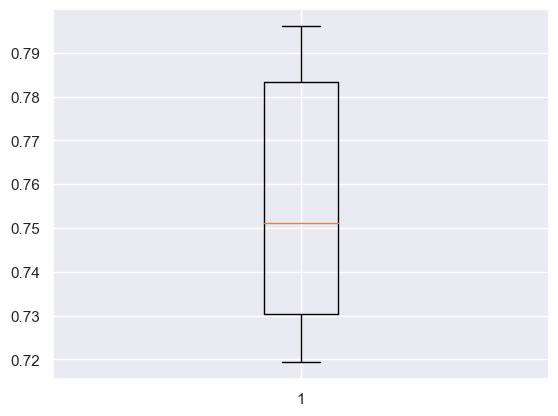

In [27]:
AUC_PolicyType_SVMSMOTE = list()

for (i,data) in enumerate(SVMDataSets):
    
    print("Starting i =",i)
    X_train, y_train, X_valid, y_valid = data

    r = {"a":'0 + C(PolicyType)'}
    mod = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
          C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_train)
    fit = mod.fit_vb()
    
    if i == 1:
        print(fit.summary())

    # Train dataset stuff
    params = fit.params
    exog_fixed = mod.exog
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
    
    ones = np.ones((exog_fixed.shape[0], mod.k_vcp))
    exog_variable = mod.exog_vc.toarray()
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
        print(exog_fixed.shape)
        print(ones.shape)
    
    XRand_train = np.hstack((exog_fixed,ones,exog_variable))
    
    if i == 1:
        print(XRand_train.shape)
    
    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_train))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)
    
    if i == 1:
        print(metrics.classification_report(y_train,y_pred))
    
    auc = metrics.roc_auc_score(y_train, y_pred_proba)

    if i == 1:
        print("Area under curve for train dataset is - ", auc)

    # Test Dataset stuff

    params = fit.params

    r = {"a":'0 + C(PolicyType)'}
    mod2 = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
         C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_valid)

    _ = mod2.fit_vb()

    exog_fixed = mod2.exog

    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp , mod2.k_vcp)

    ones = np.ones((exog_fixed.shape[0], mod2.k_vcp))
    exog_variable = mod2.exog_vc.toarray()

    if i == 1:
        print(exog_fixed.shape)
        print(ones.shape)

    XRand_valid = np.hstack((exog_fixed,ones,exog_variable))
    print(XRand_valid.shape)

    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_valid))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)

    if i == 1:
        print(metrics.classification_report(y_valid,y_pred))
        
    auc = metrics.roc_auc_score(y_valid, y_pred_proba)

    if i == 1:
        print("Area under curve is - ", auc)
    
    AUC_PolicyType_SVMSMOTE.append(auc)

plt.figure()
plt.boxplot(AUC_PolicyType_SVMSMOTE)

In [98]:
fp= open(r'./AUC_PolicyType_SVMSMOTE.txt', 'w')
fp.write(str(AUC_PolicyType_SVMSMOTE))
fp.close()


np.mean(AUC_PolicyType_SVMSMOTE)

0.7555178245124817

# SVM Resampling - MultiLevel Modelling with VehicleCategory 

Starting i = 0
(11598, 53)
Starting i = 1
                             Binomial Mixed GLM Results
                                      Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
------------------------------------------------------------------------------------
Intercept                                M     0.5996   0.0202                      
C(NumberOfCars)[T.2 vehicles]            M    -0.2451   0.0962                      
C(NumberOfCars)[T.3 to 4]                M     0.0308   0.1222                      
C(NumberOfCars)[T.5 to 8]                M     0.0530   0.6278                      
C(NumberOfCars)[T.more than 8]           M    -2.0065   1.4900                      
C(Fault)[T.Third Party]                  M    -3.1454   0.0779                      
VehiclePrice[T.30000 to 39000]           M     0.3751   0.0453                      
VehiclePrice[T.40000 to 59000]           M     0.7227   0.1209                      
VehiclePrice[T.60000 to 69000]           M     0.799

{'whiskers': [<matplotlib.lines.Line2D at 0x1c51e466220>,
 'caps': [<matplotlib.lines.Line2D at 0x1c51dfd3220>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c51e466a90>],
 'medians': [<matplotlib.lines.Line2D at 0x1c51dfd37c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c51dfd3a90>],
 'means': []}

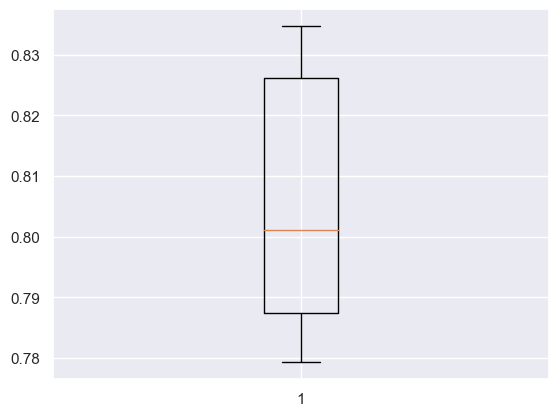

In [28]:
AUC_VehicleCategory_SVMSMOTE = list()

for (i,data) in enumerate(SVMDataSets):
    
    print("Starting i =",i)
    X_train, y_train, X_valid, y_valid = data

    r = {"a":'0 + C(VehicleCategory)'}
    mod = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
          C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_train)
    fit = mod.fit_vb()
    
    if i == 1:
        print(fit.summary())

    # Train dataset stuff
    params = fit.params
    exog_fixed = mod.exog
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
    
    ones = np.ones((exog_fixed.shape[0], mod.k_vcp))
    exog_variable = mod.exog_vc.toarray()
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
        print(exog_fixed.shape)
        print(ones.shape)
    
    XRand_train = np.hstack((exog_fixed,ones,exog_variable))
    
    if i == 1:
        print(XRand_train.shape)
    
    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_train))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)
    
    if i == 1:
        print(metrics.classification_report(y_train,y_pred))
    
    auc = metrics.roc_auc_score(y_train, y_pred_proba)

    if i == 1:
        print("Area under curve for train dataset is - ", auc)

    # Test Dataset stuff

    params = fit.params

    r = {"a":'0 + C(VehicleCategory)'}
    mod2 = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
         C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_valid)

    _ = mod2.fit_vb()

    exog_fixed = mod2.exog

    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp , mod2.k_vcp)

    ones = np.ones((exog_fixed.shape[0], mod2.k_vcp))
    exog_variable = mod2.exog_vc.toarray()

    if i == 1:
        print(exog_fixed.shape)
        print(ones.shape)

    XRand_valid = np.hstack((exog_fixed,ones,exog_variable))
    print(XRand_valid.shape)

    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_valid))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)

    if i == 1:
        print(metrics.classification_report(y_valid,y_pred))
        
    auc = metrics.roc_auc_score(y_valid, y_pred_proba)

    if i == 1:
        print("Area under curve is - ", auc)
    
    AUC_VehicleCategory_SVMSMOTE.append(auc)

plt.figure()
plt.boxplot(AUC_VehicleCategory_SVMSMOTE)

In [99]:
fp= open(r'./AUC_VehicleCategory_SVMSMOTE.txt', 'w')
fp.write(str(AUC_VehicleCategory_SVMSMOTE))
fp.close()

np.mean(AUC_VehicleCategory_SVMSMOTE)

0.8054011199356637

# SVM Resampling - MultiLevel Modelling with WitnessPresent 

Starting i = 0
(11598, 52)
Starting i = 1
                             Binomial Mixed GLM Results
                                      Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
------------------------------------------------------------------------------------
Intercept                                M     0.5983   0.0202                      
C(NumberOfCars)[T.2 vehicles]            M    -0.2451   0.0962                      
C(NumberOfCars)[T.3 to 4]                M     0.0308   0.1222                      
C(NumberOfCars)[T.5 to 8]                M     0.0530   0.6278                      
C(NumberOfCars)[T.more than 8]           M    -2.0064   1.4900                      
C(Fault)[T.Third Party]                  M    -3.1453   0.0779                      
VehiclePrice[T.30000 to 39000]           M     0.3751   0.0453                      
VehiclePrice[T.40000 to 59000]           M     0.7227   0.1209                      
VehiclePrice[T.60000 to 69000]           M     0.799

{'whiskers': [<matplotlib.lines.Line2D at 0x1c51e0f4070>,
 'caps': [<matplotlib.lines.Line2D at 0x1c51e0e54f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c51e0f4400>],
 'medians': [<matplotlib.lines.Line2D at 0x1c51e0e5ac0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c51e0e5d90>],
 'means': []}

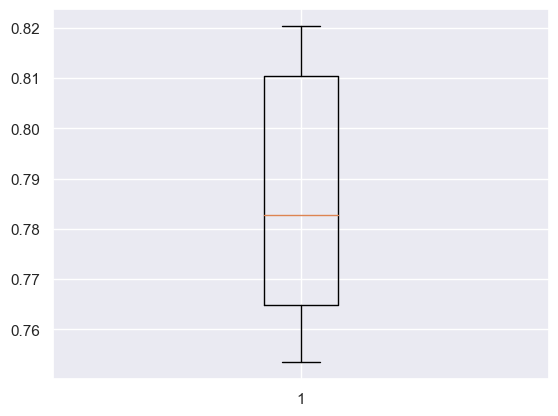

In [29]:
AUC_WitnessPresent_SVMSMOTE = list()

for (i,data) in enumerate(SVMDataSets):
    
    print("Starting i =",i)
    X_train, y_train, X_valid, y_valid = data

    r = {"a":'0 + C(WitnessPresent)'}
    mod = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
          C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_train)
    fit = mod.fit_vb()
    
    if i == 1:
        print(fit.summary())

    # Train dataset stuff
    params = fit.params
    exog_fixed = mod.exog
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
    
    ones = np.ones((exog_fixed.shape[0], mod.k_vcp))
    exog_variable = mod.exog_vc.toarray()
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
        print(exog_fixed.shape)
        print(ones.shape)
    
    XRand_train = np.hstack((exog_fixed,ones,exog_variable))
    
    if i == 1:
        print(XRand_train.shape)
    
    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_train))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)
    
    if i == 1:
        print(metrics.classification_report(y_train,y_pred))
    
    auc = metrics.roc_auc_score(y_train, y_pred_proba)

    if i == 1:
        print("Area under curve for train dataset is - ", auc)

    # Test Dataset stuff

    params = fit.params

    r = {"a":'0 + C(WitnessPresent)'}
    mod2 = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
         C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_valid)

    _ = mod2.fit_vb()

    exog_fixed = mod2.exog

    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp , mod2.k_vcp)

    ones = np.ones((exog_fixed.shape[0], mod2.k_vcp))
    exog_variable = mod2.exog_vc.toarray()

    if i == 1:
        print(exog_fixed.shape)
        print(ones.shape)

    XRand_valid = np.hstack((exog_fixed,ones,exog_variable))
    print(XRand_valid.shape)

    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_valid))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)

    if i == 1:
        print(metrics.classification_report(y_valid,y_pred))
        
    auc = metrics.roc_auc_score(y_valid, y_pred_proba)

    if i == 1:
        print("Area under curve is - ", auc)
    
    AUC_WitnessPresent_SVMSMOTE.append(auc)

plt.figure()
plt.boxplot(AUC_WitnessPresent_SVMSMOTE)

In [100]:
fp= open(r'./AUC_WitnessPresent_SVMSMOTE.txt', 'w')
fp.write(str(AUC_WitnessPresent_SVMSMOTE))
fp.close()

np.mean(AUC_WitnessPresent_SVMSMOTE)

0.7864793777302446

# SVM Resampling - MultiLevel Modelling with Make - 

Starting i = 0
(11598, 67)
Starting i = 1
                             Binomial Mixed GLM Results
                                      Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
------------------------------------------------------------------------------------
Intercept                                M     0.5961   0.0202                      
C(NumberOfCars)[T.2 vehicles]            M    -0.2451   0.0962                      
C(NumberOfCars)[T.3 to 4]                M     0.0309   0.1223                      
C(NumberOfCars)[T.5 to 8]                M     0.0530   0.6278                      
C(NumberOfCars)[T.more than 8]           M    -2.0066   1.4901                      
C(Fault)[T.Third Party]                  M    -3.1456   0.0779                      
VehiclePrice[T.30000 to 39000]           M     0.3751   0.0453                      
VehiclePrice[T.40000 to 59000]           M     0.7228   0.1209                      
VehiclePrice[T.60000 to 69000]           M     0.799

C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Number of V^2 parameters is -  1 1
(11598, 49)
(11598, 1)
(11598, 67)
              precision    recall  f1-score   support

           0       0.68      0.82      0.75      5870
           1       0.77      0.61      0.68      5728

    accuracy                           0.72     11598
   macro avg       0.73      0.72      0.71     11598
weighted avg       0.73      0.72      0.71     11598

Area under curve is -  0.7609169041999373
Starting i = 2
(11598, 67)
Starting i = 3
(11598, 67)
Starting i = 4
(11598, 67)
Starting i = 5
(11598, 67)
Starting i = 6
(11598, 67)
Starting i = 7
(11598, 67)
Starting i = 8
(11598, 67)
Starting i = 9
(11598, 67)
Starting i = 10
(11598, 67)
Starting i = 11
(11598, 67)
Starting i = 12
(11598, 67)
Starting i = 13
(11598, 67)
Starting i = 14
(11598, 67)
Starting i = 15
(11598, 67)
Starting i = 16
(11598, 67)
Starting i = 17
(11598, 67)
Starting i = 18
(11598, 67)
Starting i = 19
(11598, 67)


{'whiskers': [<matplotlib.lines.Line2D at 0x1c51e133370>,
 'caps': [<matplotlib.lines.Line2D at 0x1c51e1334f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c51e133b50>],
 'medians': [<matplotlib.lines.Line2D at 0x1c51e144340>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c51e144610>],
 'means': []}

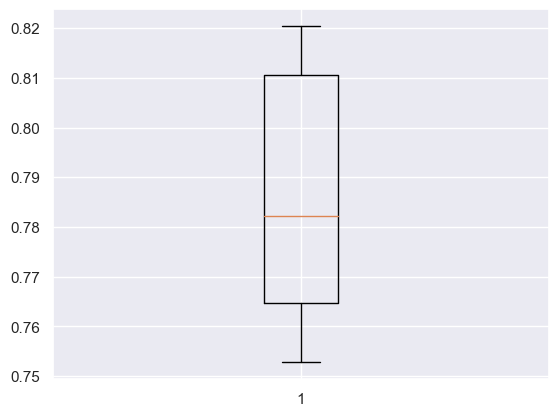

In [30]:
AUC_Make_SVMSMOTE = list()

for (i,data) in enumerate(SVMDataSets):
    
    print("Starting i =",i)
    X_train, y_train, X_valid, y_valid = data

    r = {"a":'0 + C(Make)'}
    mod = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
          C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_train)
    fit = mod.fit_vb()
    
    if i == 1:
        print(fit.summary())

    # Train dataset stuff
    params = fit.params
    exog_fixed = mod.exog
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
    
    ones = np.ones((exog_fixed.shape[0], mod.k_vcp))
    exog_variable = mod.exog_vc.toarray()
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
        print(exog_fixed.shape)
        print(ones.shape)
    
    XRand_train = np.hstack((exog_fixed,ones,exog_variable))
    
    if i == 1:
        print(XRand_train.shape)
    
    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_train))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)
    
    if i == 1:
        print(metrics.classification_report(y_train,y_pred))
    
    auc = metrics.roc_auc_score(y_train, y_pred_proba)

    if i == 1:
        print("Area under curve for train dataset is - ", auc)

    # Test Dataset stuff

    params = fit.params

    r = {"a":'0 + C(Make)'}
    mod2 = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
         C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_valid)

    _ = mod2.fit_vb()

    exog_fixed = mod2.exog

    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp , mod2.k_vcp)

    ones = np.ones((exog_fixed.shape[0], mod2.k_vcp))
    exog_variable = mod2.exog_vc.toarray()

    if i == 1:
        print(exog_fixed.shape)
        print(ones.shape)

    XRand_valid = np.hstack((exog_fixed,ones,exog_variable))
    print(XRand_valid.shape)

    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_valid))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)

    if i == 1:
        print(metrics.classification_report(y_valid,y_pred))
        
    auc = metrics.roc_auc_score(y_valid, y_pred_proba)

    if i == 1:
        print("Area under curve is - ", auc)
    
    AUC_Make_SVMSMOTE.append(auc)

plt.figure()
plt.boxplot(AUC_Make_SVMSMOTE)

In [101]:
fp= open(r'./AUC_Make_SVMSMOTE.txt', 'w')
fp.write(str(AUC_Make_SVMSMOTE))
fp.close()

np.mean(AUC_Make_SVMSMOTE)

0.786203907045578

# SVM Resampling - MultiLevel Modelling with BasePolicy - 

Starting i = 0
(11598, 53)
Starting i = 1
                             Binomial Mixed GLM Results
                                      Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
------------------------------------------------------------------------------------
Intercept                                M     0.6024   0.0202                      
C(NumberOfCars)[T.2 vehicles]            M    -0.2451   0.0962                      
C(NumberOfCars)[T.3 to 4]                M     0.0308   0.1222                      
C(NumberOfCars)[T.5 to 8]                M     0.0530   0.6278                      
C(NumberOfCars)[T.more than 8]           M    -2.0065   1.4901                      
C(Fault)[T.Third Party]                  M    -3.1454   0.0779                      
VehiclePrice[T.30000 to 39000]           M     0.3751   0.0453                      
VehiclePrice[T.40000 to 59000]           M     0.7227   0.1209                      
VehiclePrice[T.60000 to 69000]           M     0.799

{'whiskers': [<matplotlib.lines.Line2D at 0x1c51e0bb4f0>,
 'caps': [<matplotlib.lines.Line2D at 0x1c51e0bba90>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c51e0bb220>],
 'medians': [<matplotlib.lines.Line2D at 0x1c51e0bc070>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c51e0bc340>],
 'means': []}

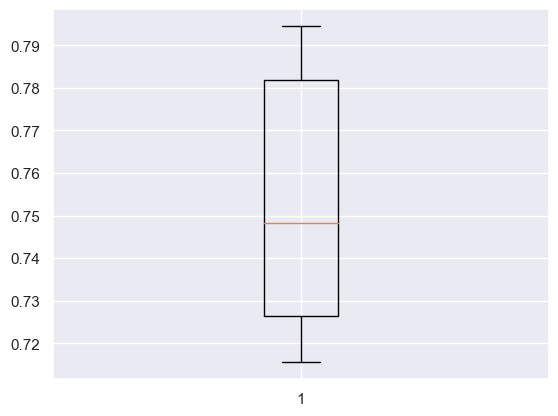

In [31]:
AUC_BasePolicy_SVMSMOTE = list()

for (i,data) in enumerate(SVMDataSets):
    
    print("Starting i =",i)
    X_train, y_train, X_valid, y_valid = data

    r = {"a":'0 + C(BasePolicy)'}
    mod = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
          C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_train)
    fit = mod.fit_vb()
    
    if i == 1:
        print(fit.summary())

    # Train dataset stuff
    params = fit.params
    exog_fixed = mod.exog
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
    
    ones = np.ones((exog_fixed.shape[0], mod.k_vcp))
    exog_variable = mod.exog_vc.toarray()
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
        print(exog_fixed.shape)
        print(ones.shape)
    
    XRand_train = np.hstack((exog_fixed,ones,exog_variable))
    
    if i == 1:
        print(XRand_train.shape)
    
    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_train))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)
    
    if i == 1:
        print(metrics.classification_report(y_train,y_pred))
    
    auc = metrics.roc_auc_score(y_train, y_pred_proba)

    if i == 1:
        print("Area under curve for train dataset is - ", auc)

    # Test Dataset stuff

    params = fit.params

    r = {"a":'0 + C(BasePolicy)'}
    mod2 = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
         C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_valid)

    _ = mod2.fit_vb()

    exog_fixed = mod2.exog

    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp , mod2.k_vcp)

    ones = np.ones((exog_fixed.shape[0], mod2.k_vcp))
    exog_variable = mod2.exog_vc.toarray()

    if i == 1:
        print(exog_fixed.shape)
        print(ones.shape)

    XRand_valid = np.hstack((exog_fixed,ones,exog_variable))
    print(XRand_valid.shape)

    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_valid))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)

    if i == 1:
        print(metrics.classification_report(y_valid,y_pred))
        
    auc = metrics.roc_auc_score(y_valid, y_pred_proba)

    if i == 1:
        print("Area under curve is - ", auc)
    
    AUC_BasePolicy_SVMSMOTE.append(auc)

plt.figure()
plt.boxplot(AUC_BasePolicy_SVMSMOTE)

In [102]:
fp= open(r'./AUC_BasePolicy_SVMSMOTE.txt', 'w')
fp.write(str(AUC_BasePolicy_SVMSMOTE))
fp.close()

np.mean(AUC_BasePolicy_SVMSMOTE)

0.7688276008108648

# SVM Resampling - MultiLevel Modelling with AgeOfVehicle - 

In [70]:
AUC_AgeOfVehicle_SVMSMOTE = list()

for (i,data) in enumerate(SVMDataSets):
    
    print("Starting i =",i)
    X_train, y_train, X_valid, y_valid = data

    r = {"a":'0 + C(AgeOfVehicle)'}
    mod = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
          C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_train)
    fit = mod.fit_vb()
    
    if i == 1:
        print(fit.summary())

    # Train dataset stuff
    params = fit.params
    exog_fixed = mod.exog
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
    
    ones = np.ones((exog_fixed.shape[0], mod.k_vcp))
    exog_variable = mod.exog_vc.toarray()
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
        print(exog_fixed.shape)
        print(ones.shape)
    
    XRand_train = np.hstack((exog_fixed,ones,exog_variable))
    
    if i == 1:
        print(XRand_train.shape)
    
    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_train))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)
    
    if i == 1:
        print(metrics.classification_report(y_train,y_pred))
    
    auc = metrics.roc_auc_score(y_train, y_pred_proba)

    if i == 1:
        print("Area under curve for train dataset is - ", auc)

    # Test Dataset stuff

    params = fit.params

    r = {"a":'0 + C(AgeOfVehicle)'}
    mod2 = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
         C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_valid)

    _ = mod2.fit_vb()

    exog_fixed = mod2.exog

    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp , mod2.k_vcp)

    ones = np.ones((exog_fixed.shape[0], mod2.k_vcp))
    exog_variable = mod2.exog_vc.toarray()

    if i == 1:
        print(exog_fixed.shape)
        print(ones.shape)

    XRand_valid = np.hstack((exog_fixed,ones,exog_variable))
    print(XRand_valid.shape)

    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_valid))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)

    if i == 1:
        print(metrics.classification_report(y_valid,y_pred))
        
    auc = metrics.roc_auc_score(y_valid, y_pred_proba)

    if i == 1:
        print("Area under curve is - ", auc)
    
    AUC_AgeOfVehicle_SVMSMOTE.append(auc)

plt.figure()
plt.boxplot(AUC_AgeOfVehicle_SVMSMOTE)

Starting i = 0
(11598, 58)
Starting i = 1
                             Binomial Mixed GLM Results
                                      Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
------------------------------------------------------------------------------------
Intercept                                M     0.6098   0.0202                      
C(NumberOfCars)[T.2 vehicles]            M    -0.2451   0.0962                      
C(NumberOfCars)[T.3 to 4]                M     0.0308   0.1223                      
C(NumberOfCars)[T.5 to 8]                M     0.0530   0.6278                      
C(NumberOfCars)[T.more than 8]           M    -2.0065   1.4901                      
C(Fault)[T.Third Party]                  M    -3.1456   0.0779                      
VehiclePrice[T.30000 to 39000]           M     0.3752   0.0453                      
VehiclePrice[T.40000 to 59000]           M     0.7228   0.1209                      
VehiclePrice[T.60000 to 69000]           M     0.799

C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Number of V^2 parameters is -  1 1
(11598, 49)
(11598, 1)
(11598, 58)
              precision    recall  f1-score   support

           0       0.68      0.82      0.75      5870
           1       0.77      0.61      0.68      5728

    accuracy                           0.72     11598
   macro avg       0.73      0.72      0.71     11598
weighted avg       0.73      0.72      0.71     11598

Area under curve is -  0.760081086482731
Starting i = 2


KeyboardInterrupt: 

In [103]:
fp= open(r'./AUC_AgeOfVehicle_SVMSMOTE.txt', 'w')
fp.write(str(AUC_AgeOfVehicle_SVMSMOTE))
fp.close()

np.mean(AUC_AgeOfVehicle_SVMSMOTE)

0.762391600660969

{'whiskers': [<matplotlib.lines.Line2D at 0x1c51c29fb20>,
 'caps': [<matplotlib.lines.Line2D at 0x1c51c2a22e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c51c29f6a0>],
 'medians': [<matplotlib.lines.Line2D at 0x1c51c2a7550>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c51c2a7820>],
 'means': []}

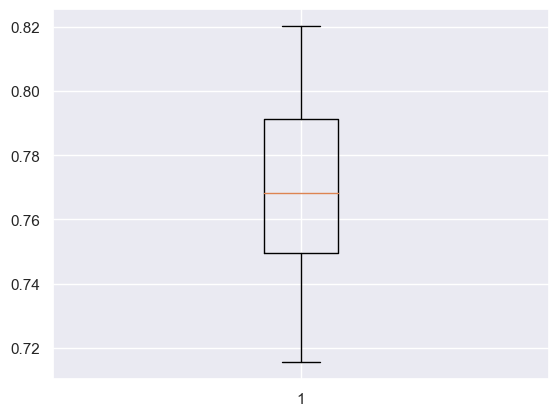

In [104]:
plt.figure()
plt.boxplot(AUC_BasePolicy_SVMSMOTE)

# UnderSampling

In [77]:
# SMOTE Sampling 

X = DummiesData.drop(columns=['FraudFound_P'])
y = DummiesData['FraudFound_P']

counter = Counter(y)
print(counter)

UnderSamplingDataSets = list()

for i in range(20):
    under = RandomUnderSampler(sampling_strategy=1, random_state=i)
    steps = [('u', under)]
    SMOTESampling = SamplingPipeline(steps=steps)

    X_resampled, y_resampled = SMOTESampling.fit_resample(X, y)
    # summarize the new class distribution
    counter = Counter(y_resampled)
    
    if i == 1:
        print(counter)

    # Verifying un dummify works
    X_resampled = undummify(X_resampled)
    
    if i == 1:
        print(X_resampled.head())

    X_train,X_valid,y_train,y_valid = train_test_split(X_resampled,y_resampled, train_size=0.6, random_state=1)

    if i == 1:
        counter = Counter(y_train)
        print(counter)
        counter = Counter(y_valid)
        print(counter)

    X_train['FraudFound_P'] = y_train
    X_valid['FraudFound_P'] = y_valid

    #print(X_train.head())
    print(X_train.shape)
    
    UnderSamplingDataSets.append([X_train, y_train, X_valid, y_valid])

Counter({0: 14497, 1: 923})
(1107, 11)
Counter({0: 923, 1: 923})
  NumberOfCars          Fault     VehiclePrice VehicleCategory  \
0    1 vehicle    Third Party   20000 to 29000           Sedan   
1    1 vehicle  Policy Holder  more than 69000           Sport   
2    1 vehicle    Third Party   20000 to 29000           Sport   
3    1 vehicle  Policy Holder   40000 to 59000         Utility   
4    1 vehicle  Policy Holder   20000 to 29000           Sedan   

            PolicyType WitnessPresent     Make  BasePolicy AgeOfVehicle  \
0    Sedan - Collision             No    Mazda   Collision      6 years   
1    Sedan - Liability             No   Toyota   Liability      7 years   
2    Sedan - Liability             No    Mazda   Liability      6 years   
3  Utility - Collision             No  Ferrari   Collision      7 years   
4   Sedan - All Perils             No  Pontiac  All Perils  more than 7   

  PastNumberOfClaims  
0             2 to 4  
1             2 to 4  
2             2 to

In [78]:
len(UnderSamplingDataSets)

20

# Under Resampling - MultiLevel Modelling with NumberOfCars 

In [81]:
AUC_AgeOfVehicle_UnderSample = list()

for (i,data) in enumerate(UnderSamplingDataSets):
    
    print("Starting i =",i)
    X_train, y_train, X_valid, y_valid = data

    r = {"a":'0 + C(AgeOfVehicle)'}
    mod = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
          C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_train)
    fit = mod.fit_vb()
    
    if i == 0:
        print(fit.summary())

    # Train dataset stuff
    params = fit.params
    exog_fixed = mod.exog
    
    if i == 0:
        print("Number of V^2 parameters is - ",mod.k_vcp)
    
    ones = np.ones((exog_fixed.shape[0], mod.k_vcp))
    exog_variable = mod.exog_vc.toarray()
    
    if i == 0:
        print("Number of V^2 parameters is - ",mod.k_vcp)
        print(exog_fixed.shape)
        print(ones.shape)
    
    XRand_train = np.hstack((exog_fixed,ones,exog_variable))
    
    if i == 0:
        print(XRand_train.shape)
    
    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_train))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)
    
    if i == 0:
        print(metrics.classification_report(y_train,y_pred))
    
    auc = metrics.roc_auc_score(y_train, y_pred_proba)

    if i == 0:
        print("Area under curve for train dataset is - ", auc)

    # Test Dataset stuff

    params = fit.params
    
    if i == 0:
        print(fit.summary())

    r = {"a":'0 + C(AgeOfVehicle)'}
    mod2 = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
         C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_valid)

    _ = mod2.fit_vb()

    exog_fixed = mod2.exog

    if i == 0:
        print("Number of V^2 parameters is - ",mod.k_vcp , mod2.k_vcp)

    ones = np.ones((exog_fixed.shape[0], mod2.k_vcp))
    exog_variable = mod2.exog_vc.toarray()

    if i == 0:
        print(exog_fixed.shape)
        print(ones.shape)

    XRand_valid = np.hstack((exog_fixed,ones,exog_variable))
    print(XRand_valid.shape)

    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_valid))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)

    if i == 0:
        print(metrics.classification_report(y_valid,y_pred))
        
    auc = metrics.roc_auc_score(y_valid, y_pred_proba)

    if i == 0:
        print("Area under curve is - ", auc)
    
    AUC_AgeOfVehicle_UnderSample.append(auc)

plt.figure()
plt.boxplot(AUC_AgeOfVehicle_UnderSample)

Starting i = 0
                             Binomial Mixed GLM Results
                                      Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
------------------------------------------------------------------------------------
Intercept                                M     1.2136   0.0759                      
C(NumberOfCars)[T.2 vehicles]            M     0.0937   0.3181                      
C(NumberOfCars)[T.3 to 4]                M     0.7398   0.4332                      
C(NumberOfCars)[T.5 to 8]                M    -1.7432   1.5277                      
C(NumberOfCars)[T.more than 8]           M    -1.9545   1.5243                      
C(Fault)[T.Third Party]                  M    -3.0438   0.2376                      
VehiclePrice[T.30000 to 39000]           M     0.1227   0.1669                      
VehiclePrice[T.40000 to 59000]           M     0.4334   0.4118                      
VehiclePrice[T.60000 to 69000]           M     1.1855   0.8201                 

Number of V^2 parameters is -  1 1
(739, 45)
(739, 1)
(739, 54)


ValueError: shapes (739,54) and (53,) not aligned: 54 (dim 1) != 53 (dim 0)

In [ ]:
np.mean(AUC_NumberOfCars_UnderSampling)

# Under Resampling - MultiLevel Modelling with PolicyType 

Starting i = 0
(11598, 59)
Starting i = 1
                             Binomial Mixed GLM Results
                                      Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
------------------------------------------------------------------------------------
Intercept                                M     0.6343   0.0188                      
C(NumberOfCars)[T.2 vehicles]            M    -0.1672   0.0863                      
C(NumberOfCars)[T.3 to 4]                M     0.1005   0.1092                      
C(NumberOfCars)[T.5 to 8]                M     0.6959   0.4812                      
C(NumberOfCars)[T.more than 8]           M    -1.8291   1.4705                      
C(Fault)[T.Third Party]                  M    -2.8555   0.0627                      
VehiclePrice[T.30000 to 39000]           M     0.3336   0.0414                      
VehiclePrice[T.40000 to 59000]           M     0.6031   0.1111                      
VehiclePrice[T.60000 to 69000]           M     0.914

{'whiskers': [<matplotlib.lines.Line2D at 0x1c51c30e400>,
 'caps': [<matplotlib.lines.Line2D at 0x1c51b4daac0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c5199da790>],
 'medians': [<matplotlib.lines.Line2D at 0x1c51b4dac70>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c51b4d5a30>],
 'means': []}

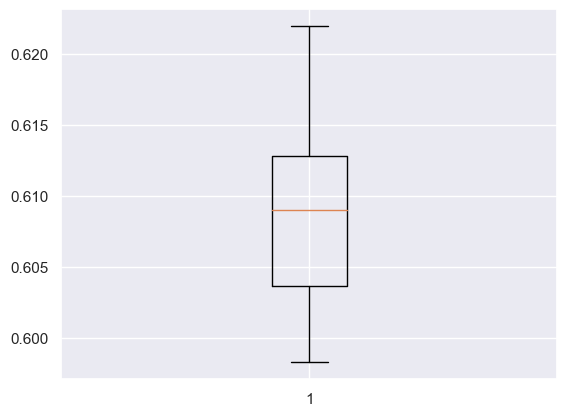

In [19]:
AUC_PolicyType_BorderlineSMOTE = list()

for (i,data) in enumerate(BorderLineDataSets):
    
    print("Starting i =",i)
    X_train, y_train, X_valid, y_valid = data

    r = {"a":'0 + C(PolicyType)'}
    mod = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
          C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_train)
    fit = mod.fit_vb()
    
    if i == 1:
        print(fit.summary())

    # Train dataset stuff
    params = fit.params
    exog_fixed = mod.exog
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
    
    ones = np.ones((exog_fixed.shape[0], mod.k_vcp))
    exog_variable = mod.exog_vc.toarray()
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
        print(exog_fixed.shape)
        print(ones.shape)
    
    XRand_train = np.hstack((exog_fixed,ones,exog_variable))
    
    if i == 1:
        print(XRand_train.shape)
    
    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_train))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)
    
    if i == 1:
        print(metrics.classification_report(y_train,y_pred))
    
    auc = metrics.roc_auc_score(y_train, y_pred_proba)

    if i == 1:
        print("Area under curve for train dataset is - ", auc)

    # Test Dataset stuff

    params = fit.params

    r = {"a":'0 + C(PolicyType)'}
    mod2 = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
         C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_valid)

    _ = mod2.fit_vb()

    exog_fixed = mod2.exog

    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp , mod2.k_vcp)

    ones = np.ones((exog_fixed.shape[0], mod2.k_vcp))
    exog_variable = mod2.exog_vc.toarray()

    if i == 1:
        print(exog_fixed.shape)
        print(ones.shape)

    XRand_valid = np.hstack((exog_fixed,ones,exog_variable))
    print(XRand_valid.shape)

    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_valid))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)

    if i == 1:
        print(metrics.classification_report(y_valid,y_pred))
        
    auc = metrics.roc_auc_score(y_valid, y_pred_proba)

    if i == 1:
        print("Area under curve is - ", auc)
    
    AUC_PolicyType_BorderlineSMOTE.append(auc)

plt.figure()
plt.boxplot(AUC_PolicyType_BorderlineSMOTE)

In [43]:
np.mean(AUC_PolicyType_BorderlineSMOTE)

0.6088312113958867

# Borderline Resampling - MultiLevel Modelling with VehicleCategory 

Starting i = 0
(11598, 53)
Starting i = 1
                             Binomial Mixed GLM Results
                                      Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
------------------------------------------------------------------------------------
Intercept                                M     0.6327   0.0188                      
C(NumberOfCars)[T.2 vehicles]            M    -0.1672   0.0863                      
C(NumberOfCars)[T.3 to 4]                M     0.1005   0.1092                      
C(NumberOfCars)[T.5 to 8]                M     0.6959   0.4812                      
C(NumberOfCars)[T.more than 8]           M    -1.8291   1.4705                      
C(Fault)[T.Third Party]                  M    -2.8553   0.0627                      
VehiclePrice[T.30000 to 39000]           M     0.3336   0.0414                      
VehiclePrice[T.40000 to 59000]           M     0.6031   0.1111                      
VehiclePrice[T.60000 to 69000]           M     0.914

{'whiskers': [<matplotlib.lines.Line2D at 0x1c51b4dce80>,
 'caps': [<matplotlib.lines.Line2D at 0x1c51b4dc6d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c51b58f8b0>],
 'medians': [<matplotlib.lines.Line2D at 0x1c51b4dce20>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c51b4dcdf0>],
 'means': []}

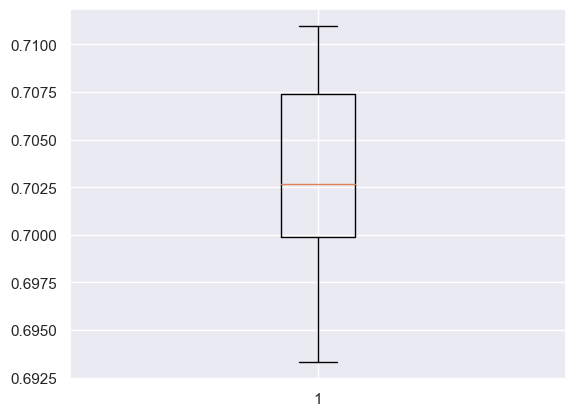

In [20]:
AUC_VehicleCategory_BorderlineSMOTE = list()

for (i,data) in enumerate(BorderLineDataSets):
    
    print("Starting i =",i)
    X_train, y_train, X_valid, y_valid = data

    r = {"a":'0 + C(VehicleCategory)'}
    mod = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
          C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_train)
    fit = mod.fit_vb()
    
    if i == 1:
        print(fit.summary())

    # Train dataset stuff
    params = fit.params
    exog_fixed = mod.exog
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
    
    ones = np.ones((exog_fixed.shape[0], mod.k_vcp))
    exog_variable = mod.exog_vc.toarray()
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
        print(exog_fixed.shape)
        print(ones.shape)
    
    XRand_train = np.hstack((exog_fixed,ones,exog_variable))
    
    if i == 1:
        print(XRand_train.shape)
    
    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_train))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)
    
    if i == 1:
        print(metrics.classification_report(y_train,y_pred))
    
    auc = metrics.roc_auc_score(y_train, y_pred_proba)

    if i == 1:
        print("Area under curve for train dataset is - ", auc)

    # Test Dataset stuff

    params = fit.params

    r = {"a":'0 + C(VehicleCategory)'}
    mod2 = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
         C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_valid)

    _ = mod2.fit_vb()

    exog_fixed = mod2.exog

    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp , mod2.k_vcp)

    ones = np.ones((exog_fixed.shape[0], mod2.k_vcp))
    exog_variable = mod2.exog_vc.toarray()

    if i == 1:
        print(exog_fixed.shape)
        print(ones.shape)

    XRand_valid = np.hstack((exog_fixed,ones,exog_variable))
    print(XRand_valid.shape)

    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_valid))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)

    if i == 1:
        print(metrics.classification_report(y_valid,y_pred))
        
    auc = metrics.roc_auc_score(y_valid, y_pred_proba)

    if i == 1:
        print("Area under curve is - ", auc)
    
    AUC_VehicleCategory_BorderlineSMOTE.append(auc)

plt.figure()
plt.boxplot(AUC_VehicleCategory_BorderlineSMOTE)

In [44]:
np.mean(AUC_VehicleCategory_BorderlineSMOTE)

0.702850860235265

# Borderline Resampling - MultiLevel Modelling with WitnessPresent 

Starting i = 0
(11598, 52)
Starting i = 1
                             Binomial Mixed GLM Results
                                      Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
------------------------------------------------------------------------------------
Intercept                                M     0.6297   0.0188                      
C(NumberOfCars)[T.2 vehicles]            M    -0.1672   0.0863                      
C(NumberOfCars)[T.3 to 4]                M     0.1005   0.1092                      
C(NumberOfCars)[T.5 to 8]                M     0.6959   0.4812                      
C(NumberOfCars)[T.more than 8]           M    -1.8291   1.4705                      
C(Fault)[T.Third Party]                  M    -2.8552   0.0627                      
VehiclePrice[T.30000 to 39000]           M     0.3336   0.0414                      
VehiclePrice[T.40000 to 59000]           M     0.6031   0.1111                      
VehiclePrice[T.60000 to 69000]           M     0.914

{'whiskers': [<matplotlib.lines.Line2D at 0x1c51b5ac2b0>,
 'caps': [<matplotlib.lines.Line2D at 0x1c51b5acc10>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c51b5ac7f0>],
 'medians': [<matplotlib.lines.Line2D at 0x1c51b5acb20>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c51b596250>],
 'means': []}

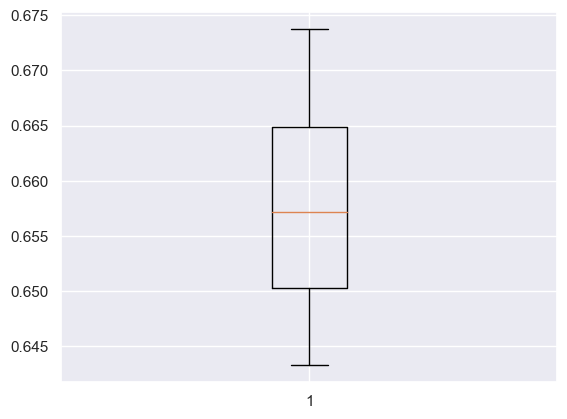

In [21]:
AUC_WitnessPresent_BorderlineSMOTE = list()

for (i,data) in enumerate(BorderLineDataSets):
    
    print("Starting i =",i)
    X_train, y_train, X_valid, y_valid = data

    r = {"a":'0 + C(WitnessPresent)'}
    mod = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
          C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_train)
    fit = mod.fit_vb()
    
    if i == 1:
        print(fit.summary())

    # Train dataset stuff
    params = fit.params
    exog_fixed = mod.exog
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
    
    ones = np.ones((exog_fixed.shape[0], mod.k_vcp))
    exog_variable = mod.exog_vc.toarray()
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
        print(exog_fixed.shape)
        print(ones.shape)
    
    XRand_train = np.hstack((exog_fixed,ones,exog_variable))
    
    if i == 1:
        print(XRand_train.shape)
    
    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_train))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)
    
    if i == 1:
        print(metrics.classification_report(y_train,y_pred))
    
    auc = metrics.roc_auc_score(y_train, y_pred_proba)

    if i == 1:
        print("Area under curve for train dataset is - ", auc)

    # Test Dataset stuff

    params = fit.params

    r = {"a":'0 + C(WitnessPresent)'}
    mod2 = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
         C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_valid)

    _ = mod2.fit_vb()

    exog_fixed = mod2.exog

    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp , mod2.k_vcp)

    ones = np.ones((exog_fixed.shape[0], mod2.k_vcp))
    exog_variable = mod2.exog_vc.toarray()

    if i == 1:
        print(exog_fixed.shape)
        print(ones.shape)

    XRand_valid = np.hstack((exog_fixed,ones,exog_variable))
    print(XRand_valid.shape)

    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_valid))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)

    if i == 1:
        print(metrics.classification_report(y_valid,y_pred))
        
    auc = metrics.roc_auc_score(y_valid, y_pred_proba)

    if i == 1:
        print("Area under curve is - ", auc)
    
    AUC_WitnessPresent_BorderlineSMOTE.append(auc)

plt.figure()
plt.boxplot(AUC_WitnessPresent_BorderlineSMOTE)

In [45]:
np.mean(AUC_WitnessPresent_BorderlineSMOTE)

0.6576744367606329

# Borderline Resampling - MultiLevel Modelling with Make - 

Starting i = 0
(11598, 67)
Starting i = 1
                             Binomial Mixed GLM Results
                                      Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
------------------------------------------------------------------------------------
Intercept                                M     0.6296   0.0188                      
C(NumberOfCars)[T.2 vehicles]            M    -0.1672   0.0863                      
C(NumberOfCars)[T.3 to 4]                M     0.1006   0.1092                      
C(NumberOfCars)[T.5 to 8]                M     0.6959   0.4812                      
C(NumberOfCars)[T.more than 8]           M    -1.8292   1.4705                      
C(Fault)[T.Third Party]                  M    -2.8556   0.0627                      
VehiclePrice[T.30000 to 39000]           M     0.3336   0.0414                      
VehiclePrice[T.40000 to 59000]           M     0.6032   0.1111                      
VehiclePrice[T.60000 to 69000]           M     0.914

C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\athimmas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Number of V^2 parameters is -  1 1
(11598, 49)
(11598, 1)
(11598, 67)
              precision    recall  f1-score   support

           0       0.61      0.75      0.67      5870
           1       0.66      0.51      0.58      5728

    accuracy                           0.63     11598
   macro avg       0.64      0.63      0.63     11598
weighted avg       0.64      0.63      0.63     11598

Area under curve is -  0.655553415839464
Starting i = 2
(11598, 67)
Starting i = 3
(11598, 67)
Starting i = 4
(11598, 67)
Starting i = 5
(11598, 67)
Starting i = 6
(11598, 67)
Starting i = 7
(11598, 67)
Starting i = 8
(11598, 67)
Starting i = 9
(11598, 67)
Starting i = 10
(11598, 67)
Starting i = 11
(11598, 67)
Starting i = 12
(11598, 67)
Starting i = 13
(11598, 67)
Starting i = 14
(11598, 67)
Starting i = 15
(11598, 67)
Starting i = 16
(11598, 67)
Starting i = 17


C:\Users\athimmas\Anaconda3\lib\site-packages\statsmodels\genmod\bayes_mixed_glm.py:793: UserWarning: VB fitting did not converge
  warnings.warn("VB fitting did not converge")


(11598, 67)
Starting i = 18
(11598, 67)
Starting i = 19
(11598, 67)


{'whiskers': [<matplotlib.lines.Line2D at 0x1c51b5b1730>,
 'caps': [<matplotlib.lines.Line2D at 0x1c51b51b2b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c51b5b1b20>],
 'medians': [<matplotlib.lines.Line2D at 0x1c51b51b850>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c51b51bb20>],
 'means': []}

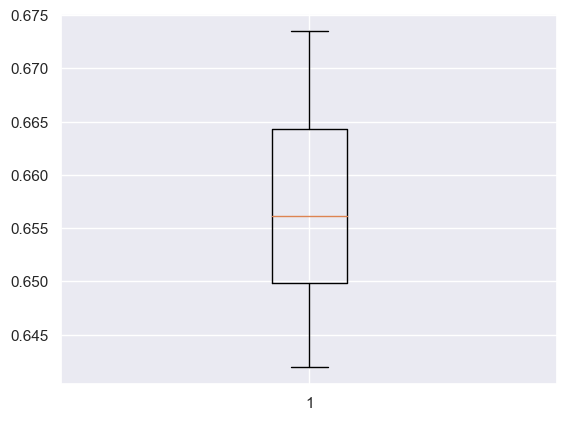

In [22]:
AUC_Make_BorderlineSMOTE = list()

for (i,data) in enumerate(BorderLineDataSets):
    
    print("Starting i =",i)
    X_train, y_train, X_valid, y_valid = data

    r = {"a":'0 + C(Make)'}
    mod = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
          C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_train)
    fit = mod.fit_vb()
    
    if i == 1:
        print(fit.summary())

    # Train dataset stuff
    params = fit.params
    exog_fixed = mod.exog
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
    
    ones = np.ones((exog_fixed.shape[0], mod.k_vcp))
    exog_variable = mod.exog_vc.toarray()
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
        print(exog_fixed.shape)
        print(ones.shape)
    
    XRand_train = np.hstack((exog_fixed,ones,exog_variable))
    
    if i == 1:
        print(XRand_train.shape)
    
    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_train))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)
    
    if i == 1:
        print(metrics.classification_report(y_train,y_pred))
    
    auc = metrics.roc_auc_score(y_train, y_pred_proba)

    if i == 1:
        print("Area under curve for train dataset is - ", auc)

    # Test Dataset stuff

    params = fit.params

    r = {"a":'0 + C(Make)'}
    mod2 = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
         C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_valid)

    _ = mod2.fit_vb()

    exog_fixed = mod2.exog

    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp , mod2.k_vcp)

    ones = np.ones((exog_fixed.shape[0], mod2.k_vcp))
    exog_variable = mod2.exog_vc.toarray()

    if i == 1:
        print(exog_fixed.shape)
        print(ones.shape)

    XRand_valid = np.hstack((exog_fixed,ones,exog_variable))
    print(XRand_valid.shape)

    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_valid))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)

    if i == 1:
        print(metrics.classification_report(y_valid,y_pred))
        
    auc = metrics.roc_auc_score(y_valid, y_pred_proba)

    if i == 1:
        print("Area under curve is - ", auc)
    
    AUC_Make_BorderlineSMOTE.append(auc)

plt.figure()
plt.boxplot(AUC_Make_BorderlineSMOTE)

In [46]:
np.mean(AUC_Make_BorderlineSMOTE)

0.6569575066263457

# Borderline Resampling - MultiLevel Modelling with BasePolicy

Starting i = 0
(11598, 53)
Starting i = 1
                             Binomial Mixed GLM Results
                                      Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
------------------------------------------------------------------------------------
Intercept                                M     0.6354   0.0188                      
C(NumberOfCars)[T.2 vehicles]            M    -0.1672   0.0863                      
C(NumberOfCars)[T.3 to 4]                M     0.1005   0.1092                      
C(NumberOfCars)[T.5 to 8]                M     0.6959   0.4812                      
C(NumberOfCars)[T.more than 8]           M    -1.8291   1.4705                      
C(Fault)[T.Third Party]                  M    -2.8553   0.0627                      
VehiclePrice[T.30000 to 39000]           M     0.3336   0.0414                      
VehiclePrice[T.40000 to 59000]           M     0.6031   0.1111                      
VehiclePrice[T.60000 to 69000]           M     0.914

{'whiskers': [<matplotlib.lines.Line2D at 0x1c51b706700>,
 'caps': [<matplotlib.lines.Line2D at 0x1c51b706ca0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c51b706430>],
 'medians': [<matplotlib.lines.Line2D at 0x1c51b6f3280>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c51b6f3550>],
 'means': []}

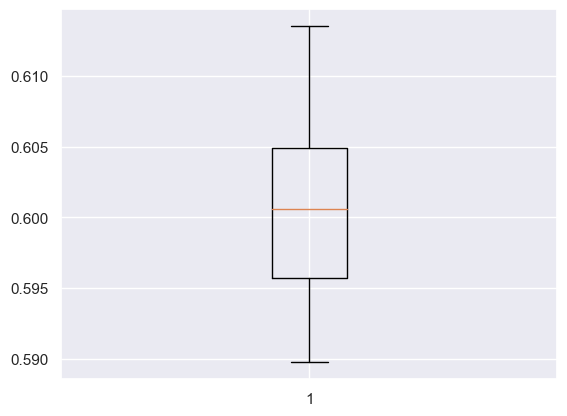

In [23]:
AUC_BasePolicy_BorderlineSMOTE = list()

for (i,data) in enumerate(BorderLineDataSets):
    
    print("Starting i =",i)
    X_train, y_train, X_valid, y_valid = data

    r = {"a":'0 + C(BasePolicy)'}
    mod = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
          C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_train)
    fit = mod.fit_vb()
    
    if i == 1:
        print(fit.summary())

    # Train dataset stuff
    params = fit.params
    exog_fixed = mod.exog
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
    
    ones = np.ones((exog_fixed.shape[0], mod.k_vcp))
    exog_variable = mod.exog_vc.toarray()
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
        print(exog_fixed.shape)
        print(ones.shape)
    
    XRand_train = np.hstack((exog_fixed,ones,exog_variable))
    
    if i == 1:
        print(XRand_train.shape)
    
    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_train))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)
    
    if i == 1:
        print(metrics.classification_report(y_train,y_pred))
    
    auc = metrics.roc_auc_score(y_train, y_pred_proba)

    if i == 1:
        print("Area under curve for train dataset is - ", auc)

    # Test Dataset stuff

    params = fit.params

    r = {"a":'0 + C(BasePolicy)'}
    mod2 = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
         C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_valid)

    _ = mod2.fit_vb()

    exog_fixed = mod2.exog

    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp , mod2.k_vcp)

    ones = np.ones((exog_fixed.shape[0], mod2.k_vcp))
    exog_variable = mod2.exog_vc.toarray()

    if i == 1:
        print(exog_fixed.shape)
        print(ones.shape)

    XRand_valid = np.hstack((exog_fixed,ones,exog_variable))
    print(XRand_valid.shape)

    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_valid))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)

    if i == 1:
        print(metrics.classification_report(y_valid,y_pred))
        
    auc = metrics.roc_auc_score(y_valid, y_pred_proba)

    if i == 1:
        print("Area under curve is - ", auc)
    
    AUC_BasePolicy_BorderlineSMOTE.append(auc)

plt.figure()
plt.boxplot(AUC_BasePolicy_BorderlineSMOTE)

In [47]:
np.mean(AUC_BasePolicy_BorderlineSMOTE)

0.6008156591131879

# Borderline Resampling - MultiLevel Modelling with AgeOfVehicle - 

Starting i = 0
(11598, 58)
Starting i = 1
                             Binomial Mixed GLM Results
                                      Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
------------------------------------------------------------------------------------
Intercept                                M     0.6420   0.0188                      
C(NumberOfCars)[T.2 vehicles]            M    -0.1672   0.0863                      
C(NumberOfCars)[T.3 to 4]                M     0.1005   0.1092                      
C(NumberOfCars)[T.5 to 8]                M     0.6959   0.4812                      
C(NumberOfCars)[T.more than 8]           M    -1.8292   1.4705                      
C(Fault)[T.Third Party]                  M    -2.8555   0.0627                      
VehiclePrice[T.30000 to 39000]           M     0.3337   0.0414                      
VehiclePrice[T.40000 to 59000]           M     0.6032   0.1111                      
VehiclePrice[T.60000 to 69000]           M     0.914

{'whiskers': [<matplotlib.lines.Line2D at 0x1c51b5f4130>,
 'caps': [<matplotlib.lines.Line2D at 0x1c51b600b50>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c51b5f4160>],
 'medians': [<matplotlib.lines.Line2D at 0x1c51b600550>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c51b600bb0>],
 'means': []}

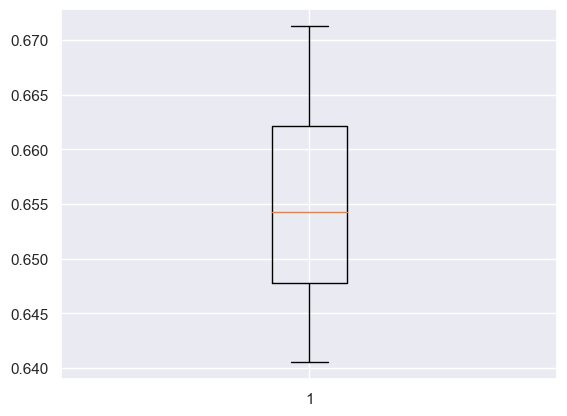

In [24]:
AUC_AgeOfVehicle_BorderlineSMOTE = list()

for (i,data) in enumerate(BorderLineDataSets):
    
    print("Starting i =",i)
    X_train, y_train, X_valid, y_valid = data

    r = {"a":'0 + C(AgeOfVehicle)'}
    mod = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
          C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_train)
    fit = mod.fit_vb()
    
    if i == 1:
        print(fit.summary())

    # Train dataset stuff
    params = fit.params
    exog_fixed = mod.exog
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
    
    ones = np.ones((exog_fixed.shape[0], mod.k_vcp))
    exog_variable = mod.exog_vc.toarray()
    
    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp)
        print(exog_fixed.shape)
        print(ones.shape)
    
    XRand_train = np.hstack((exog_fixed,ones,exog_variable))
    
    if i == 1:
        print(XRand_train.shape)
    
    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_train))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)
    
    if i == 1:
        print(metrics.classification_report(y_train,y_pred))
    
    auc = metrics.roc_auc_score(y_train, y_pred_proba)

    if i == 1:
        print("Area under curve for train dataset is - ", auc)

    # Test Dataset stuff

    params = fit.params

    r = {"a":'0 + C(AgeOfVehicle)'}
    mod2 = bbmg.from_formula('FraudFound_P ~  C(NumberOfCars) + C(Fault) + VehiclePrice + C(VehicleCategory) + \
         C(PolicyType) + C(WitnessPresent) + C(Make) + C(BasePolicy) + C(AgeOfVehicle) + PastNumberOfClaims', r , X_valid)

    _ = mod2.fit_vb()

    exog_fixed = mod2.exog

    if i == 1:
        print("Number of V^2 parameters is - ",mod.k_vcp , mod2.k_vcp)

    ones = np.ones((exog_fixed.shape[0], mod2.k_vcp))
    exog_variable = mod2.exog_vc.toarray()

    if i == 1:
        print(exog_fixed.shape)
        print(ones.shape)

    XRand_valid = np.hstack((exog_fixed,ones,exog_variable))
    print(XRand_valid.shape)

    y_pred_proba = pd.DataFrame(mod.predict(params=params,exog = XRand_valid))
    y_pred = y_pred_proba.applymap(lambda x: 1 if x > thresh else 0)

    if i == 1:
        print(metrics.classification_report(y_valid,y_pred))
        
    auc = metrics.roc_auc_score(y_valid, y_pred_proba)

    if i == 1:
        print("Area under curve is - ", auc)
    
    AUC_AgeOfVehicle_BorderlineSMOTE.append(auc)

plt.figure()
plt.boxplot(AUC_AgeOfVehicle_BorderlineSMOTE)

In [48]:
np.mean(AUC_AgeOfVehicle_BorderlineSMOTE)

0.6548845921407023